# Windy Gridworld

## 环境设置
- 网格：7行 × 10列
- 坐标系统：左上角为原点(0,0)，行号0-6，列号0-9
- 动作：8向移动（King's moves）
- 目标状态：(3,7) - episode结束
- 死亡状态：(0,9) - 奖励-100，episode结束
- 每步奖励：-1
- 风向：特定列有向上的风

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
import time

# 配置中文字体支持
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

## 算法实现

In [2]:
class WindyGridworld:
    def __init__(self, king_moves=True, absorbing_state=None):
        """
        初始化Windy Gridworld环境
        
        参数:
            king_moves: bool - 是否允许8向移动，False则只允许4向(Rook moves)
            absorbing_state: tuple - 吸收状态位置，如(0,3)，奖励+5
        """
        self.rows = 7
        self.cols = 10
        self.goal_state = (3, 7)  # 目标状态（左上角为(0,0)）
        self.death_state = (0, 9)  # 死亡状态
        self.absorbing_state = absorbing_state  # 吸收状态（任务7）
        
        # 风向定义：列索引 -> 向上推的格数（0-based索引）
        self.wind = {
            3: 1, 4: 1, 5: 1,  # 列3,4,5: 向上1格
            6: 2, 7: 2,        # 列6,7: 向上2格  
            8: 1               # 列8: 向上1格
        }
        
        # 动作定义
        if king_moves:
            # 8向移动（King's moves）
            self.actions = ['n', 'ne', 'e', 'se', 's', 'sw', 'w', 'nw']
            self.action_effects = {
                'n': (-1, 0), 'ne': (-1, 1), 'e': (0, 1), 'se': (1, 1),
                's': (1, 0), 'sw': (1, -1), 'w': (0, -1), 'nw': (-1, -1)
            }
        else:
            # 4向移动（Rook moves）
            self.actions = ['n', 'e', 's', 'w']
            self.action_effects = {
                'n': (-1, 0), 'e': (0, 1), 's': (1, 0), 'w': (0, -1)
            }
        
        # 所有状态（0-based索引）
        self.states = [(r, c) for r in range(self.rows) 
                       for c in range(self.cols)]
    
    def step(self, state, action):
        """
        执行动作，返回下一个状态和奖励
        
        返回: (next_state, reward, done)
        """
        # 如果已经在终止状态，不能再移动
        if self.is_terminal(state):
            return state, 0, True
        
        row, col = state
        d_row, d_col = self.action_effects[action]
        
        # 应用动作
        new_row = row + d_row
        new_col = col + d_col
        
        # 应用风（只影响垂直方向）
        if new_col in self.wind:
            new_row -= self.wind[new_col]  # 风向上推
        
        # 边界检查（0-based索引）
        new_row = max(0, min(self.rows - 1, new_row))
        new_col = max(0, min(self.cols - 1, new_col))
        
        next_state = (new_row, new_col)
        
        # ✅ 奖励设置（已修复）
        # 普通步骤：-1（鼓励最短路径）
        # 终止状态的即时奖励：
        if next_state == self.death_state:
            return next_state, -100, True  # 死亡：累积约-114
        elif next_state == self.absorbing_state:
            return next_state, 5, True     # 吸收：累积约-2
        elif next_state == self.goal_state:
            return next_state, 10, True    # ✅ 目标：累积约+1（最优！）
        else:
            return next_state, -1, False   # 普通步骤：-1
    
    def is_terminal(self, state):
        """判断是否为终止状态"""
        terminals = [self.goal_state, self.death_state]
        if self.absorbing_state:
            terminals.append(self.absorbing_state)
        return state in terminals
    
    def random_action(self):
        """随机选择一个动作"""
        return np.random.choice(self.actions)

In [3]:
def sarsa(env, start_state, episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.1, epsilon_decay=False, optimistic_init=0.0):
    """
    SARSA算法 (on-policy)
    
    参数:
        env: WindyGridworld环境
        start_state: 起始状态
        episodes: 训练回合数
        alpha: 学习率
        gamma: 折扣因子
        epsilon: epsilon-greedy策略的探索率（或初始探索率）
        epsilon_decay: 是否使用epsilon衰减
        optimistic_init: Q值的乐观初始化值（>0鼓励探索）
    
    返回:
        Q: Q值表
        steps_per_episode: 每个episode的步数列表
    """
    # 初始化Q表（乐观初始化鼓励探索）
    Q = {(s, a): optimistic_init for s in env.states for a in env.actions}
    
    steps_per_episode = []
    
    # Epsilon衰减参数
    epsilon_start = epsilon
    epsilon_end = 0.01
    epsilon_decay_rate = (epsilon_start - epsilon_end) / (episodes * 0.7)  # 前70%的轮次衰减
    
    for episode in range(episodes):
        # 计算当前epsilon
        if epsilon_decay:
            current_epsilon = max(epsilon_end, epsilon_start - episode * epsilon_decay_rate)
        else:
            current_epsilon = epsilon
        
        state = start_state
        
        # epsilon-greedy选择动作
        if np.random.random() < current_epsilon:
            action = env.random_action()
        else:
            action = max(env.actions, key=lambda a: Q[(state, a)])
        
        steps = 0
        
        while not env.is_terminal(state):
            # 执行动作
            next_state, reward, done = env.step(state, action)
            
            # 选择下一个动作 (on-policy)
            if not done:
                if np.random.random() < current_epsilon:
                    next_action = env.random_action()
                else:
                    next_action = max(env.actions, key=lambda a: Q[(next_state, a)])
            else:
                next_action = None
            
            # SARSA更新
            if next_action is not None:
                Q[(state, action)] += alpha * (reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            
            state = next_state
            action = next_action
            steps += 1
            
            # 防止无限循环
            if steps > 1000:
                break
        
        steps_per_episode.append(steps)
    
    return Q, steps_per_episode

In [4]:
def q_learning(env, start_state, episodes=10000, alpha=0.1, gamma=1.0, epsilon=0.1, epsilon_decay=False, optimistic_init=0.0):
    """
    Q-Learning算法 (off-policy)
    
    参数:
        env: WindyGridworld环境
        start_state: 起始状态
        episodes: 训练回合数
        alpha: 学习率
        gamma: 折扣因子
        epsilon: epsilon-greedy策略的探索率（或初始探索率）
        epsilon_decay: 是否使用epsilon衰减
        optimistic_init: Q值的乐观初始化值（>0鼓励探索）
    
    返回:
        Q: Q值表
        steps_per_episode: 每个episode的步数列表
    """
    # 初始化Q表（乐观初始化鼓励探索）
    Q = {(s, a): optimistic_init for s in env.states for a in env.actions}
    
    steps_per_episode = []
    
    # Epsilon衰减参数
    epsilon_start = epsilon
    epsilon_end = 0.01
    epsilon_decay_rate = (epsilon_start - epsilon_end) / (episodes * 0.7)  # 前70%的轮次衰减
    
    for episode in range(episodes):
        # 计算当前epsilon
        if epsilon_decay:
            current_epsilon = max(epsilon_end, epsilon_start - episode * epsilon_decay_rate)
        else:
            current_epsilon = epsilon
        
        state = start_state
        steps = 0
        
        while not env.is_terminal(state):
            # epsilon-greedy选择动作
            if np.random.random() < current_epsilon:
                action = env.random_action()
            else:
                action = max(env.actions, key=lambda a: Q[(state, a)])
            
            # 执行动作
            next_state, reward, done = env.step(state, action)
            
            # Q-Learning更新 (使用max)
            if not done:
                max_next_q = max(Q[(next_state, a)] for a in env.actions)
                Q[(state, action)] += alpha * (reward + gamma * max_next_q - Q[(state, action)])
            else:
                Q[(state, action)] += alpha * (reward - Q[(state, action)])
            
            state = next_state
            steps += 1
            
            # 防止无限循环
            if steps > 1000:
                break
        
        steps_per_episode.append(steps)
    
    return Q, steps_per_episode

In [5]:
def get_optimal_policy(Q, env):
    """从Q表提取最优策略"""
    policy = {}
    for state in env.states:
        if not env.is_terminal(state):
            policy[state] = max(env.actions, key=lambda a: Q[(state, a)])
    return policy

def get_optimal_path(policy, env, start_state, max_steps=100):
    """根据策略生成从起点到终点的路径"""
    path = [start_state]
    state = start_state
    steps = 0
    
    while not env.is_terminal(state) and steps < max_steps:
        if state in policy:
            action = policy[state]
            next_state, _, _ = env.step(state, action)
            path.append(next_state)
            state = next_state
            steps += 1
        else:
            break
    
    return path

def plot_learning_curve(steps_list, title, labels):
    """绘制学习曲线"""
    plt.figure(figsize=(12, 6))
    
    for steps, label in zip(steps_list, labels):
        # 计算移动平均
        window = 100
        if len(steps) >= window:
            smoothed = np.convolve(steps, np.ones(window)/window, mode='valid')
            plt.plot(smoothed, label=label, alpha=0.8)
    
    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode (smoothed)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_gridworld(env, path=None, policy=None, show_all_policy=False):
    """
    Visualize gridworld with origin at top-left (0,0)
    
    参数:
        show_all_policy: 如果为True，显示所有格子的策略箭头；如果为False，只显示路径上的箭头
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw grid with wind zones
    for r in range(env.rows):
        for c in range(env.cols):
            # Determine base color based on wind strength
            if c in env.wind:
                wind_strength = env.wind[c]
                if wind_strength == 1:
                    base_color = 'lightyellow'  # Weak wind
                else:  # wind_strength == 2
                    base_color = 'wheat'  # Strong wind
            else:
                base_color = 'white'  # No wind
            
            # Override color for special states
            if (r, c) == env.goal_state:
                facecolor = 'lightgreen'
            elif (r, c) == env.death_state:
                facecolor = 'black'
            elif (r, c) == env.absorbing_state:
                facecolor = 'lightblue'
            else:
                facecolor = base_color
            
            ax.add_patch(Rectangle((c, r), 1, 1, 
                                  facecolor=facecolor, edgecolor='black', linewidth=0.5))
    
    # Draw wind strength numbers at the top of each column
    for col in range(env.cols):
        wind_strength = env.wind.get(col, 0)
        if wind_strength > 0:
            ax.text(col + 0.5, -0.3, str(wind_strength), 
                   ha='center', va='center', fontsize=14, fontweight='bold',
                   color='darkred')
    
    # Draw path
    if path:
        path_x = [c + 0.5 for r, c in path]
        path_y = [r + 0.5 for r, c in path]
        ax.plot(path_x, path_y, 'r-', linewidth=2, marker='o', 
               markersize=6, label='Optimal Path')
        # Mark start
        ax.plot(path_x[0], path_y[0], 'go', markersize=12, label='Start')
    
    # Draw policy arrows
    if policy:
        arrow_map = {
            'n': (0, -0.3), 'ne': (0.2, -0.2), 'e': (0.3, 0),
            'se': (0.2, 0.2), 's': (0, 0.3), 'sw': (-0.2, 0.2),
            'w': (-0.3, 0), 'nw': (-0.2, -0.2)
        }
        
        # 确定要显示箭头的状态集合
        if show_all_policy:
            # 显示所有状态的策略
            states_to_show = policy.keys()
        else:
            # 只显示路径上的状态（去除终止状态）
            if path:
                states_to_show = [s for s in path if not env.is_terminal(s)]
            else:
                states_to_show = []
        
        for state in states_to_show:
            if state in policy and state not in [env.goal_state, env.death_state, env.absorbing_state]:
                r, c = state
                action = policy[state]
                dx, dy = arrow_map[action]
                x = c + 0.5
                y = r + 0.5
                ax.arrow(x, y, dx, dy, head_width=0.1, head_length=0.05,
                        fc='blue', ec='blue', alpha=0.5, linewidth=1.5)
    
    # Set limits and invert Y axis to make (0,0) at top-left
    ax.set_xlim(0, env.cols)
    ax.set_ylim(-0.5, env.rows)
    ax.invert_yaxis()  # ⭐ KEY: Invert Y axis so row 0 is at top
    ax.set_aspect('equal')
    
    # Remove tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    title = 'Windy Gridworld'
    ax.set_title(title, fontsize=14)
    
    # Add legend with wind info
    from matplotlib.patches import Patch
    legend_elements = []
    if path:
        legend_elements.append(plt.Line2D([0], [0], color='r', marker='o', label='Optimal Path'))
    legend_elements.extend([
        Patch(facecolor='lightyellow', edgecolor='black', label='Weak Wind (1)'),
        Patch(facecolor='wheat', edgecolor='black', label='Strong Wind (2)'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Goal'),
        Patch(facecolor='black', edgecolor='black', label='Death'),
    ])
    if env.absorbing_state:
        legend_elements.append(Patch(facecolor='lightblue', edgecolor='black', label='Absorbing'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

## 任务1: SARSA vs Q-Learning (8向移动)

**环境设置**: 8向移动 (King's Moves)  
**起始位置**: (6,0), (3,0), (0,6)  
**目标**: 找到到达(3,7)的最优策略

任务1: 8向移动 (King's Moves)

起始位置: (6, 0)

运行 SARSA...
SARSA 最优路径长度: 7 步
SARSA 路径: [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (4, 6), (3, 7)]

运行 Q-Learning...
Q-Learning 最优路径长度: 14 步
Q-Learning 路径: [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (4, 5), (2, 6), (0, 7), (0, 8), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 否
  SARSA: 7 步
  Q-Learning: 14 步

起始状态 (6, 0) 的Q值对比:
  动作 n : SARSA= -1.398, Q-learning= -4.000, 差异=  2.602
  动作 ne: SARSA=  0.295, Q-learning= -3.000, 差异=  3.295
  动作 e : SARSA=  1.024, Q-learning= -3.000, 差异=  4.024
  动作 se: SARSA=  0.501, Q-learning= -3.000, 差异=  3.501
  动作 s : SARSA=  0.141, Q-learning= -4.000, 差异=  4.141
  动作 sw: SARSA=  0.251, Q-learning= -4.000, 差异=  4.251
  动作 w : SARSA=  0.105, Q-learning= -4.000, 差异=  4.105
  动作 nw: SARSA= -1.089, Q-learning= -4.000, 差异=  2.911

绘制学习曲线...


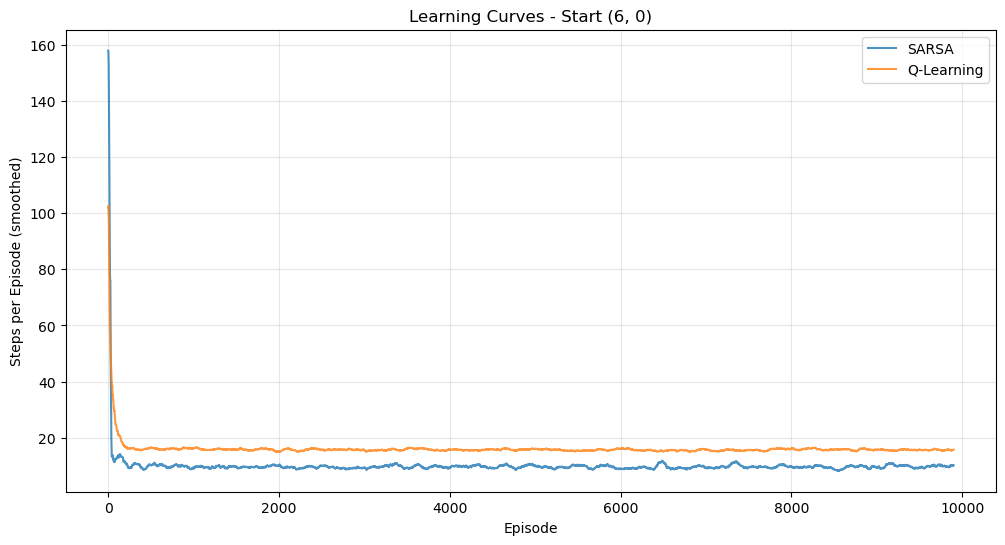


生成策略可视化...
SARSA 策略:


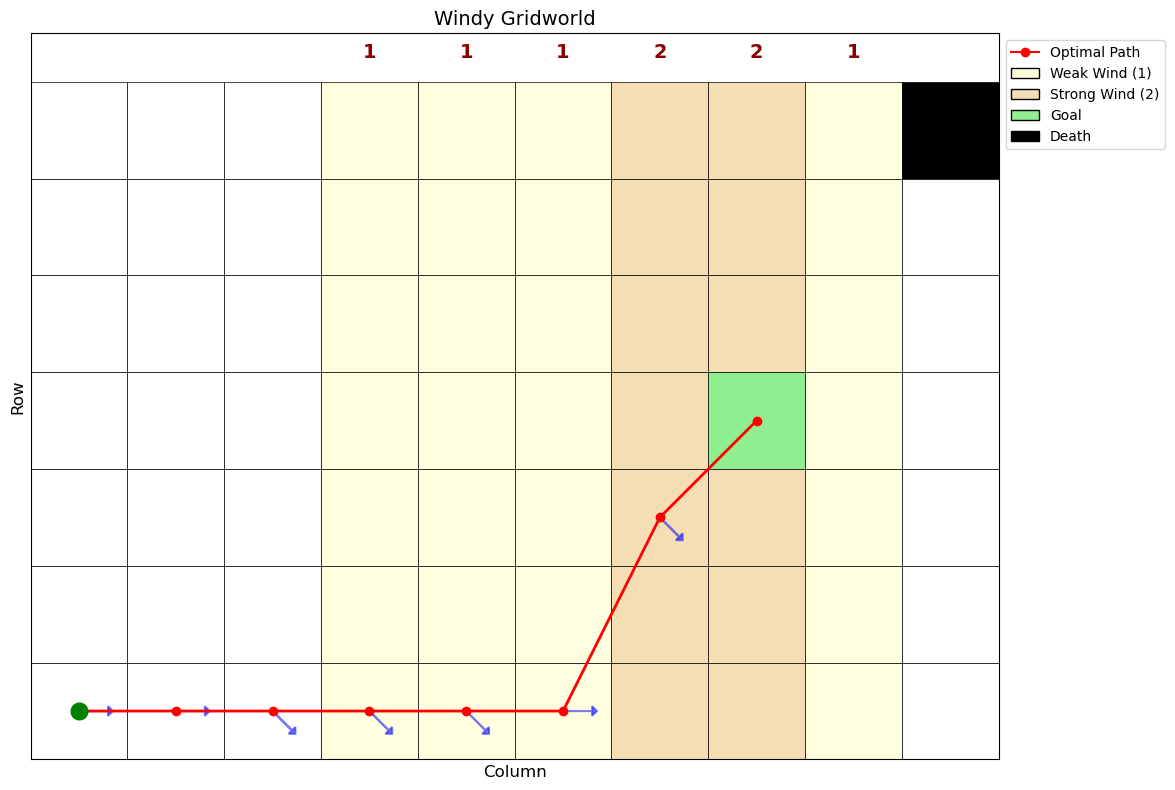

Q-Learning 策略:


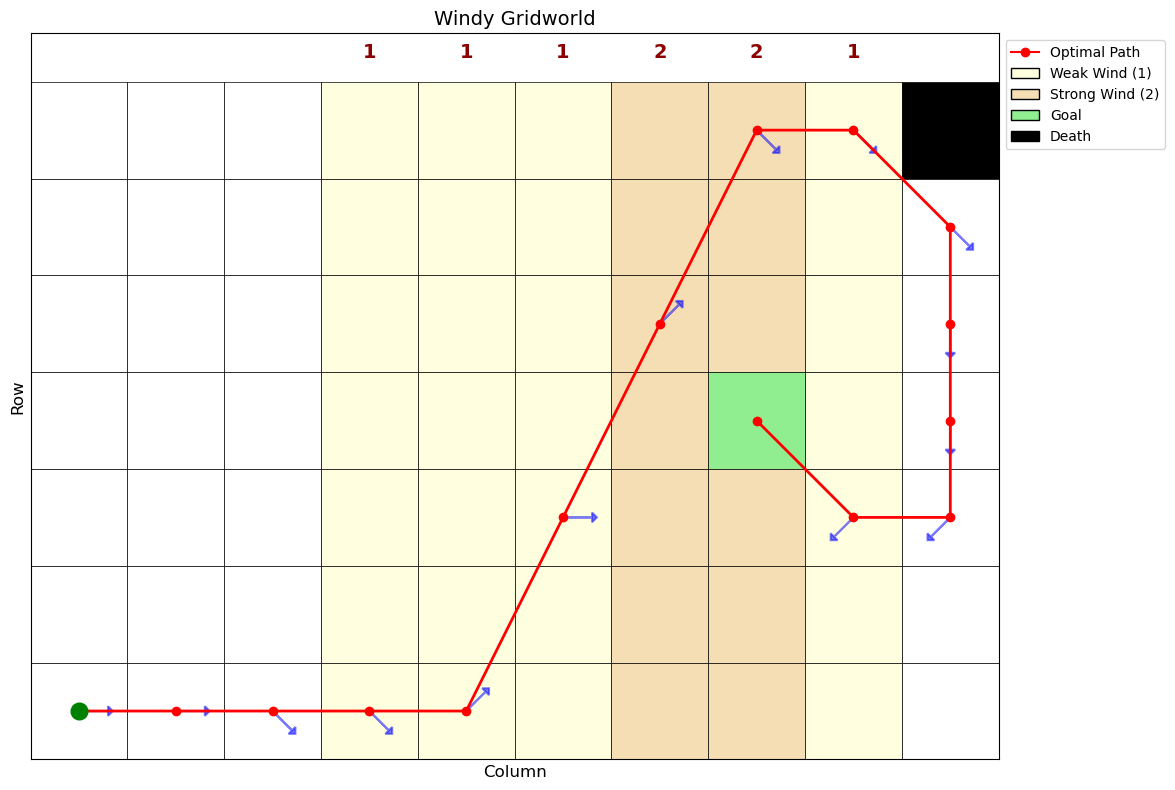


起始位置: (3, 0)

运行 SARSA...
SARSA 最优路径长度: 7 步
SARSA 路径: [(3, 0), (4, 1), (5, 2), (5, 3), (5, 4), (5, 5), (4, 6), (3, 7)]

运行 Q-Learning...
Q-Learning 最优路径长度: 14 步
Q-Learning 路径: [(3, 0), (4, 1), (5, 2), (5, 3), (4, 4), (2, 5), (1, 6), (0, 7), (0, 8), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 否
  SARSA: 7 步
  Q-Learning: 14 步

起始状态 (3, 0) 的Q值对比:
  动作 n : SARSA= -2.853, Q-learning= -4.000, 差异=  1.147
  动作 ne: SARSA= -1.813, Q-learning= -4.000, 差异=  2.187
  动作 e : SARSA= -1.631, Q-learning= -3.000, 差异=  1.369
  动作 se: SARSA=  1.271, Q-learning= -3.000, 差异=  4.271
  动作 s : SARSA= -0.472, Q-learning= -4.000, 差异=  3.528
  动作 sw: SARSA= -0.515, Q-learning= -4.000, 差异=  3.485
  动作 w : SARSA= -0.463, Q-learning= -4.000, 差异=  3.537
  动作 nw: SARSA= -2.886, Q-learning= -4.000, 差异=  1.114

绘制学习曲线...


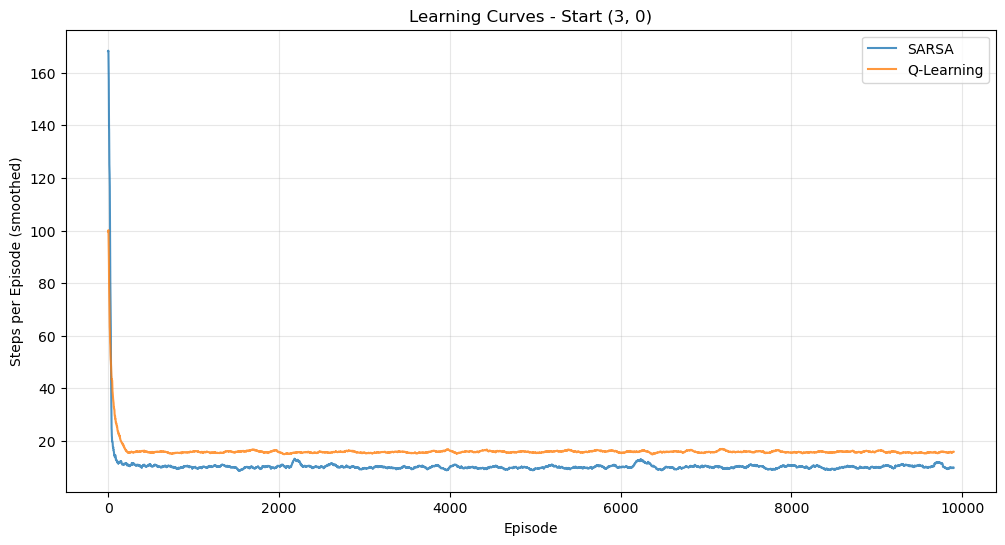


生成策略可视化...
SARSA 策略:


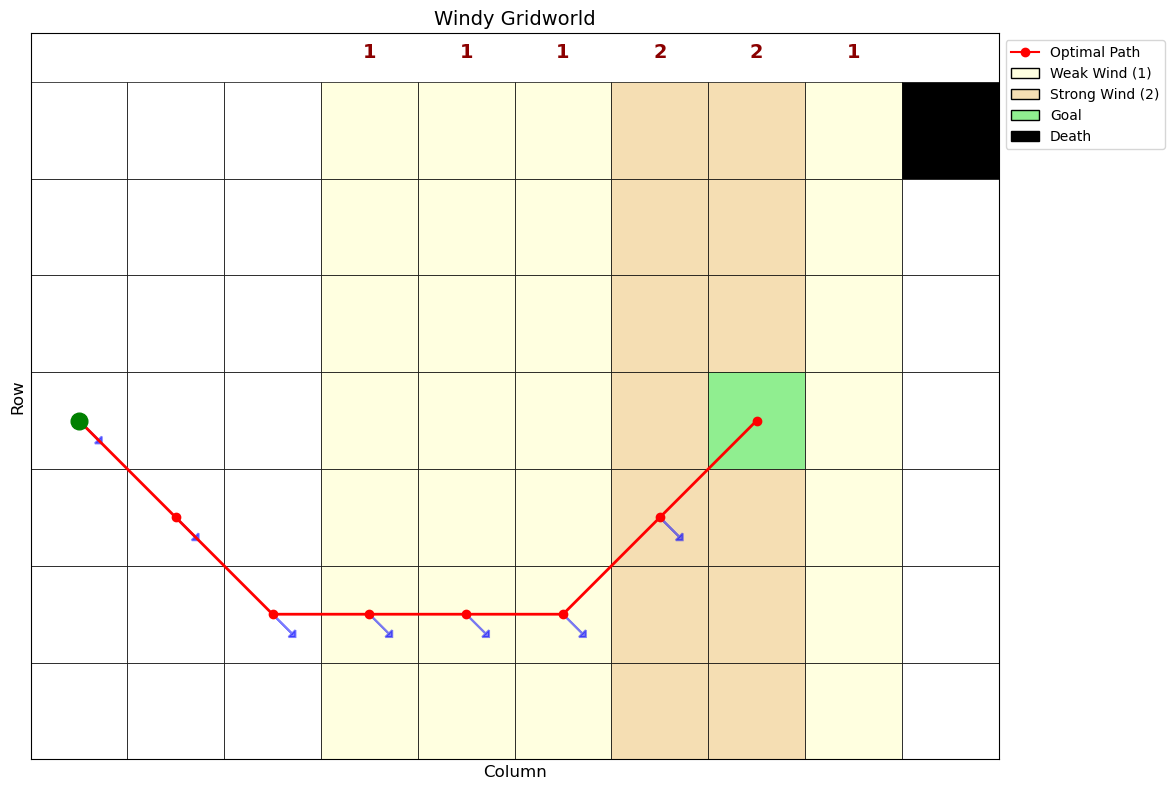

Q-Learning 策略:


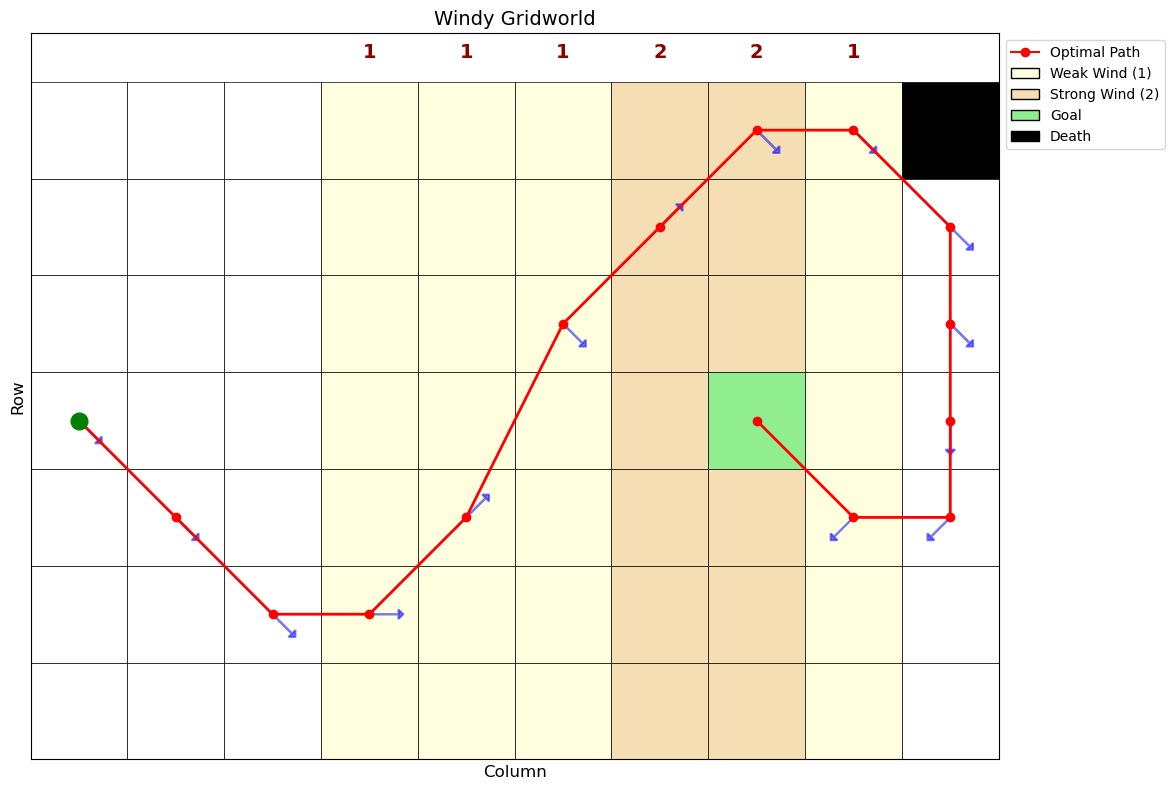


起始位置: (0, 6)

运行 SARSA...
SARSA 最优路径长度: 8 步
SARSA 路径: [(0, 6), (0, 7), (0, 8), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]

运行 Q-Learning...
Q-Learning 最优路径长度: 8 步
Q-Learning 路径: [(0, 6), (0, 7), (0, 8), (1, 9), (2, 9), (3, 9), (4, 9), (4, 8), (3, 7)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 8 步
  Q-Learning: 8 步

起始状态 (0, 6) 的Q值对比:
  动作 n : SARSA= -6.221, Q-learning=  2.000, 差异=  8.221
  动作 ne: SARSA= -6.195, Q-learning=  3.000, 差异=  9.195
  动作 e : SARSA= -6.045, Q-learning=  3.000, 差异=  9.045
  动作 se: SARSA= -2.165, Q-learning=  3.000, 差异=  5.165
  动作 s : SARSA= -6.888, Q-learning=  2.000, 差异=  8.888
  动作 sw: SARSA= -6.037, Q-learning=  1.000, 差异=  7.037
  动作 w : SARSA= -5.963, Q-learning=  1.000, 差异=  6.963
  动作 nw: SARSA= -5.885, Q-learning=  1.000, 差异=  6.885

绘制学习曲线...


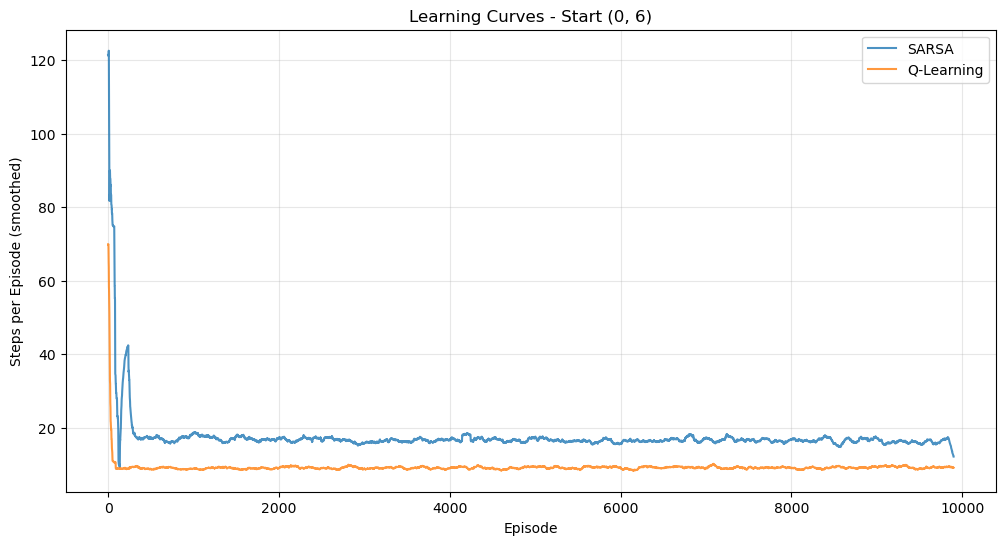


生成策略可视化...
SARSA 策略:


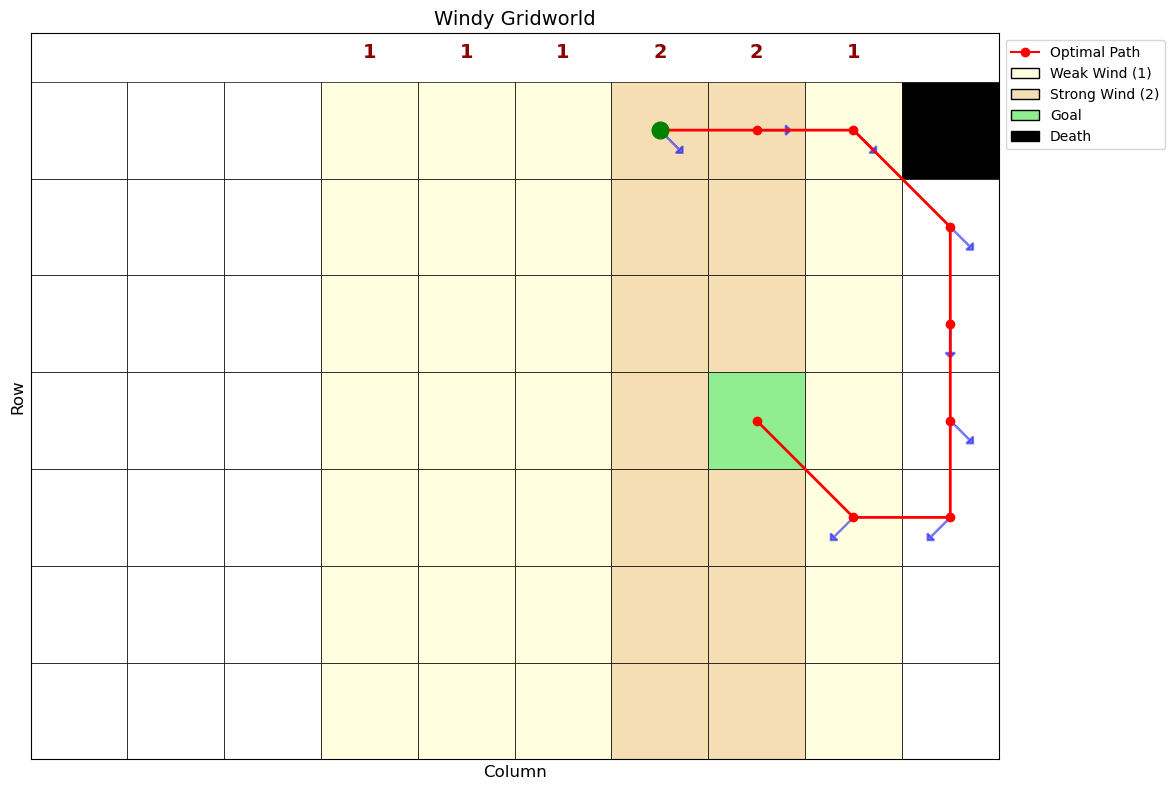

Q-Learning 策略:


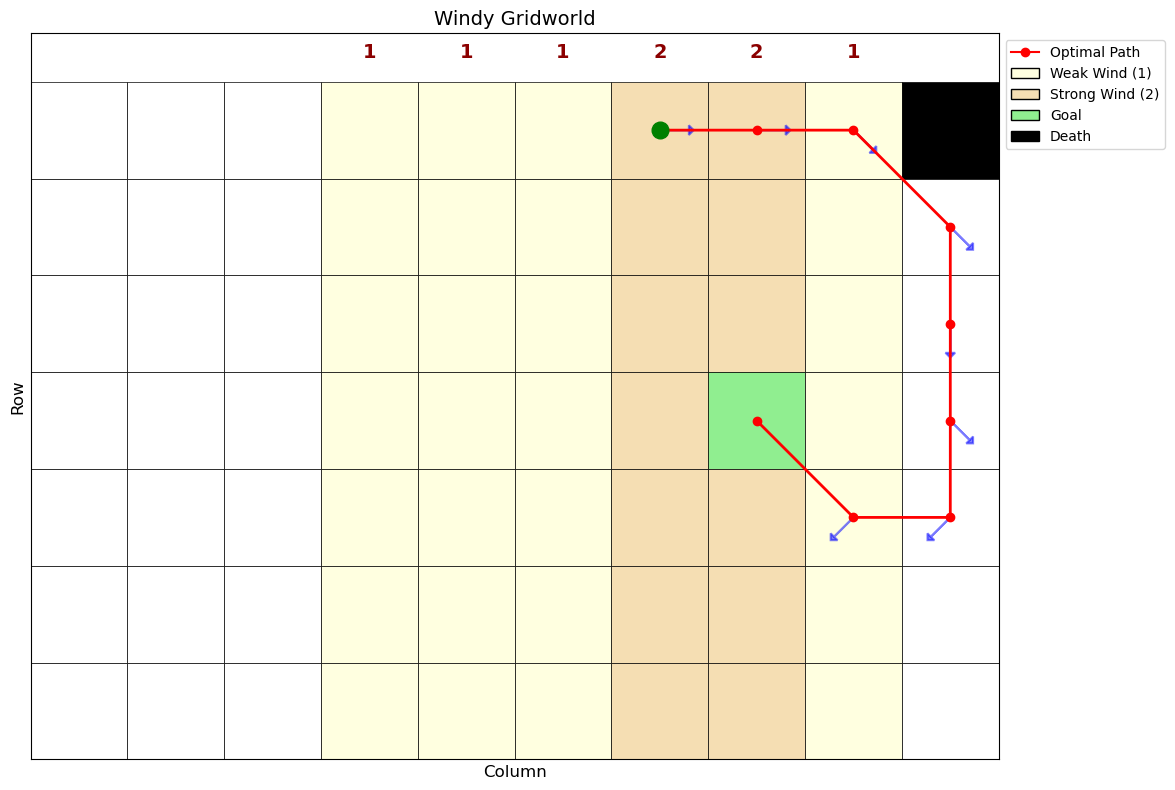

In [6]:
# 创建环境（8向移动）
env_king = WindyGridworld(king_moves=True)

# 三个起始位置（左上角为(0,0)）
start_states = [(6, 0), (3, 0), (0, 6)]

print("=" * 60)
print("任务1: 8向移动 (King's Moves)")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA...")
    Q_sarsa, steps_sarsa = sarsa(env_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_sarsa = get_optimal_policy(Q_sarsa, env_king)
    path_sarsa = get_optimal_path(policy_sarsa, env_king, start)
    print(f"SARSA 最优路径长度: {len(path_sarsa)-1} 步")
    print(f"SARSA 路径: {path_sarsa}")
    
    # Q-Learning
    print("\n运行 Q-Learning...")
    Q_qlearn, steps_qlearn = q_learning(env_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_qlearn = get_optimal_policy(Q_qlearn, env_king)
    path_qlearn = get_optimal_path(policy_qlearn, env_king, start)
    print(f"Q-Learning 最优路径长度: {len(path_qlearn)-1} 步")
    print(f"Q-Learning 路径: {path_qlearn}")
    
    # 对比分析
    print("\n" + "-"*60)
    print("对比分析:")
    print("-"*60)
    print(f"路径长度是否一致: {'是' if len(path_sarsa) == len(path_qlearn) else '否'}")
    print(f"  SARSA: {len(path_sarsa)-1} 步")
    print(f"  Q-Learning: {len(path_qlearn)-1} 步")
    
    # Q值对比（选择起始状态的Q值）
    print(f"\n起始状态 {start} 的Q值对比:")
    for action in env_king.actions:
        q_s = Q_sarsa[(start, action)]
        q_q = Q_qlearn[(start, action)]
        print(f"  动作 {action:2s}: SARSA={q_s:7.3f}, Q-learning={q_q:7.3f}, 差异={abs(q_s-q_q):7.3f}")
    
    # 绘制学习曲线对比
    print("\n绘制学习曲线...")
    plot_learning_curve([steps_sarsa, steps_qlearn], 
                       f'Learning Curves - Start {start}',
                       ['SARSA', 'Q-Learning'])
    
    # 可视化最优策略
    print("\n生成策略可视化...")
    print("SARSA 策略:")
    visualize_gridworld(env_king, path=path_sarsa, policy=policy_sarsa)
    print("Q-Learning 策略:")
    visualize_gridworld(env_king, path=path_qlearn, policy=policy_qlearn)

## 任务2: 4向移动对比

**环境设置**: 4向移动 (Rook's Moves) - 仅允许上下左右  
**起始位置**: (6,0), (3,0), (0,6)  
**对比重点**: 与任务1的8向移动结果对比

任务2: 4向移动 (Rook's Moves)

起始位置: (6, 0)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 9 步
SARSA 路径: [(6, 0), (6, 1), (6, 2), (5, 3), (4, 4), (3, 5), (1, 6), (0, 7), (0, 8), (0, 9)]

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 9 步
Q-Learning 路径: [(6, 0), (6, 1), (6, 2), (5, 3), (4, 4), (3, 5), (1, 6), (0, 7), (0, 8), (0, 9)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 9 步
  Q-Learning: 9 步

起始状态 (6, 0) 的Q值对比:
  动作 n : SARSA=-109.764, Q-learning=-109.000, 差异=  0.764
  动作 e : SARSA=-108.990, Q-learning=-108.000, 差异=  0.990
  动作 s : SARSA=-110.014, Q-learning=-109.000, 差异=  1.014
  动作 w : SARSA=-110.058, Q-learning=-109.000, 差异=  1.058

绘制学习曲线...


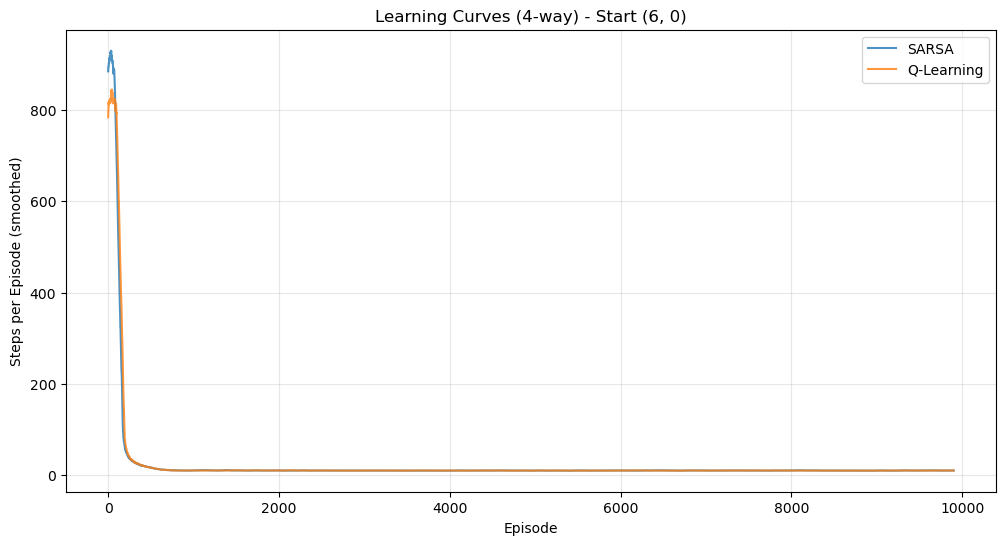


生成策略可视化...
SARSA 策略:


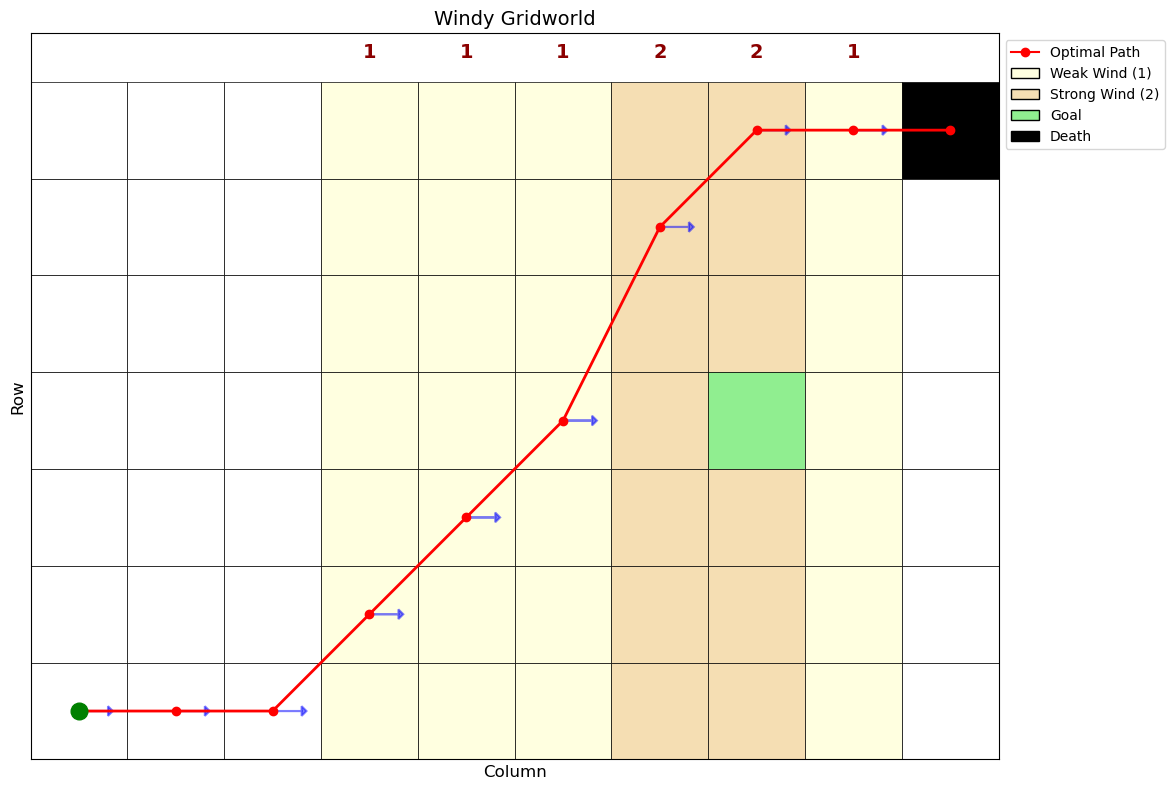

Q-Learning 策略:


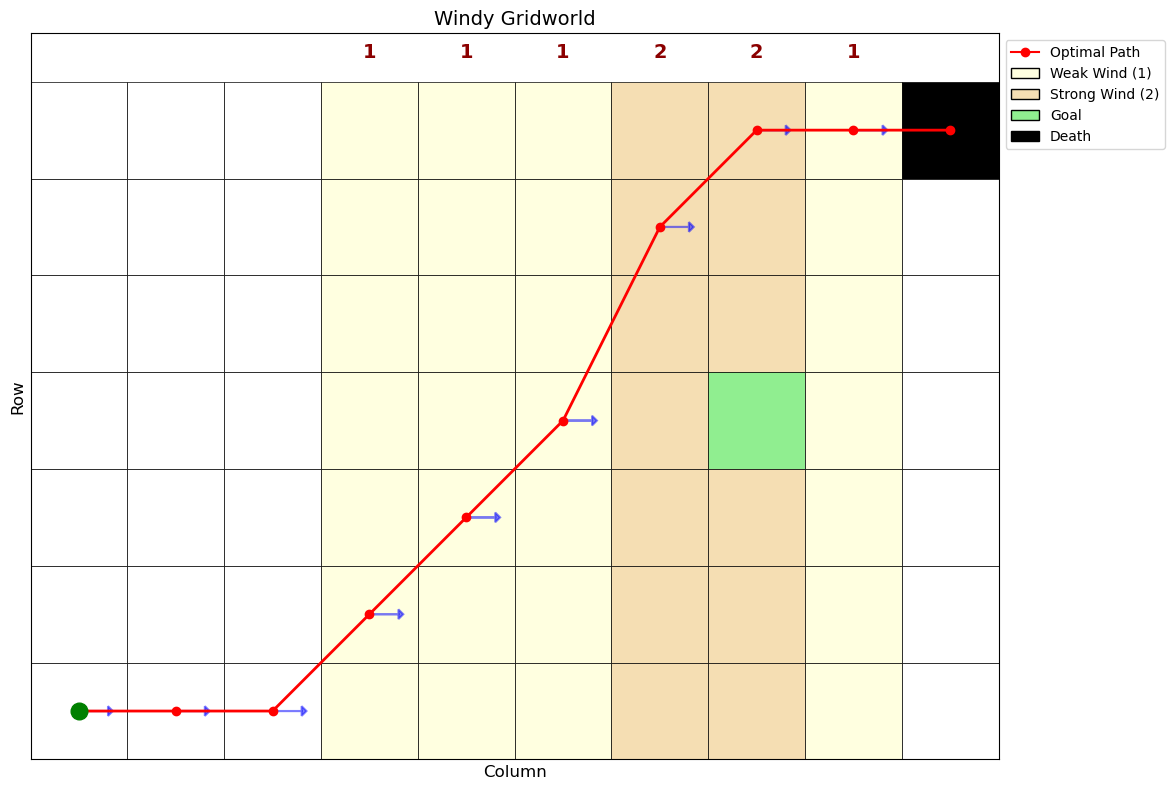


起始位置: (3, 0)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 9 步
SARSA 路径: [(3, 0), (3, 1), (3, 2), (2, 3), (1, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 9 步
Q-Learning 路径: [(3, 0), (3, 1), (3, 2), (2, 3), (1, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 9 步
  Q-Learning: 9 步

起始状态 (3, 0) 的Q值对比:
  动作 n : SARSA=-109.720, Q-learning=-109.000, 差异=  0.720
  动作 e : SARSA=-108.883, Q-learning=-108.000, 差异=  0.883
  动作 s : SARSA=-109.857, Q-learning=-109.000, 差异=  0.857
  动作 w : SARSA=-109.839, Q-learning=-109.000, 差异=  0.839

绘制学习曲线...


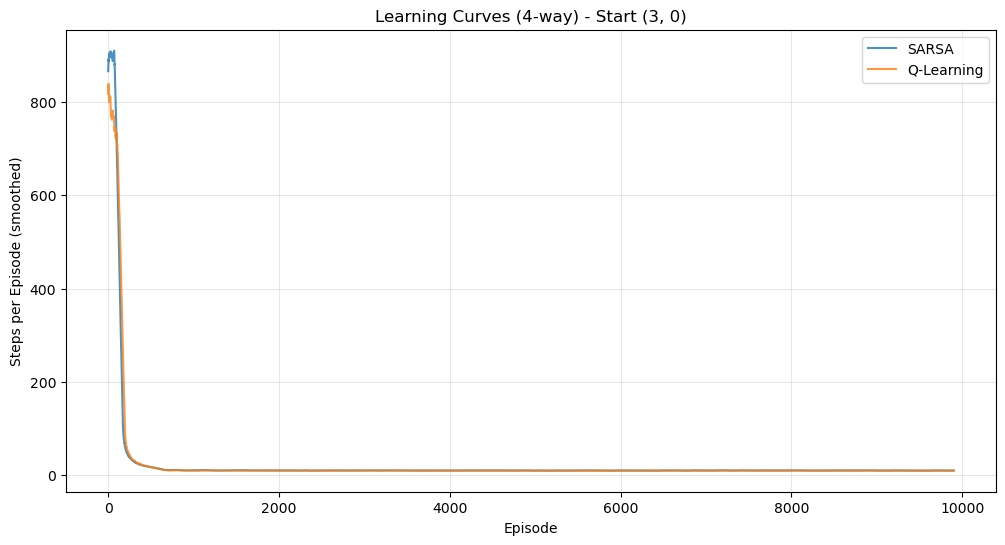


生成策略可视化...
SARSA 策略:


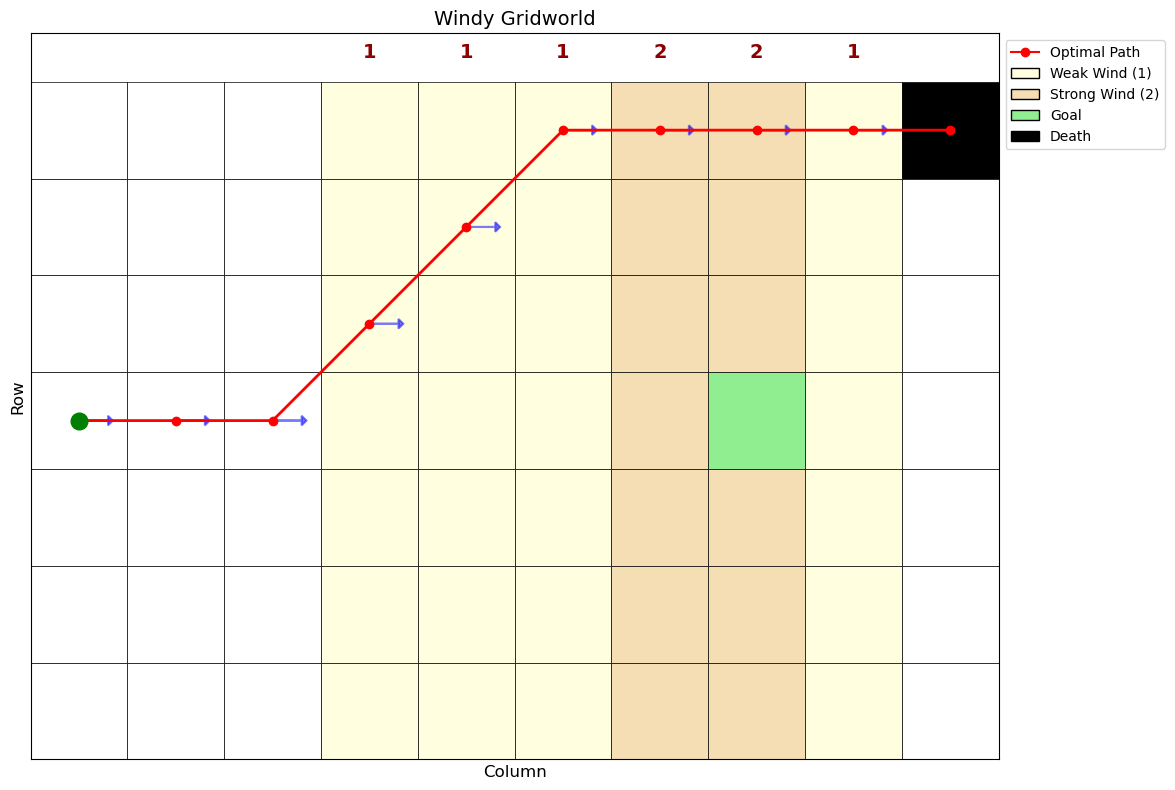

Q-Learning 策略:


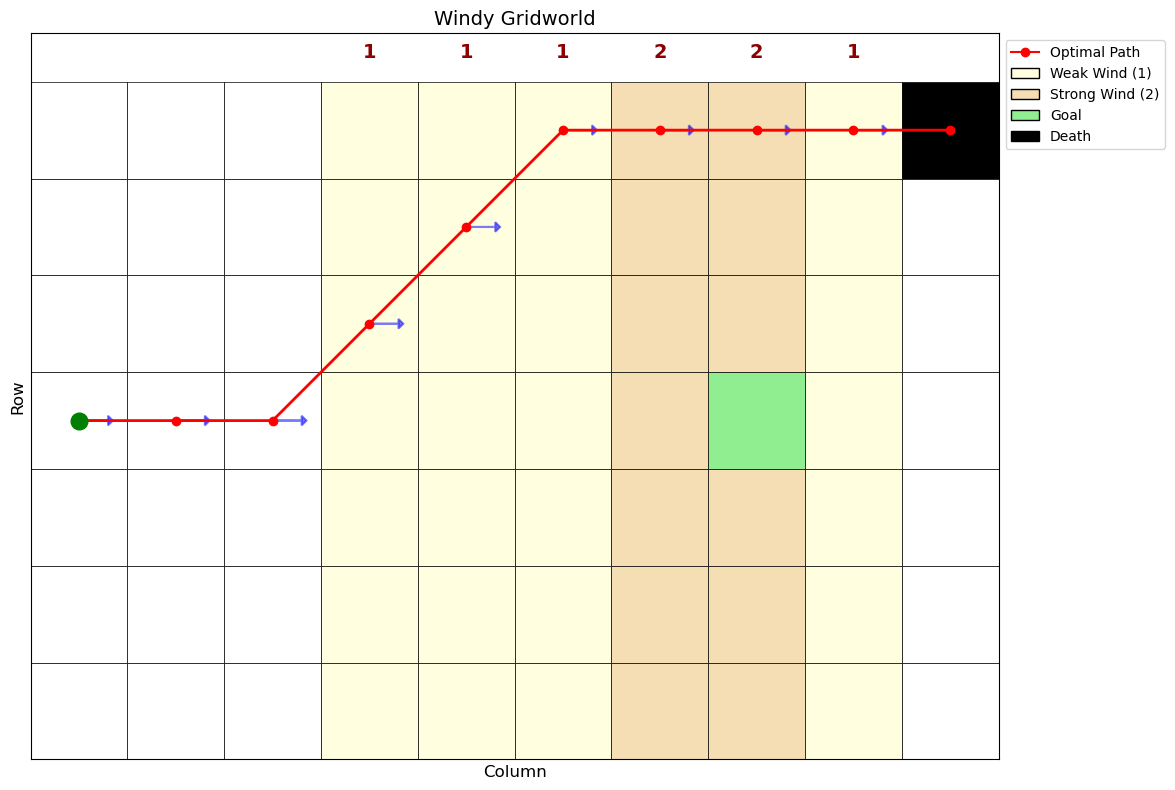


起始位置: (0, 6)

运行 SARSA (4向)...
SARSA (4向) 最优路径长度: 3 步
SARSA 路径: [(0, 6), (0, 7), (0, 8), (0, 9)]

运行 Q-Learning (4向)...
Q-Learning (4向) 最优路径长度: 3 步
Q-Learning 路径: [(0, 6), (0, 7), (0, 8), (0, 9)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 3 步
  Q-Learning: 3 步

起始状态 (0, 6) 的Q值对比:
  动作 n : SARSA=-103.283, Q-learning=-103.000, 差异=  0.283
  动作 e : SARSA=-102.311, Q-learning=-102.000, 差异=  0.311
  动作 s : SARSA=-103.297, Q-learning=-103.000, 差异=  0.297
  动作 w : SARSA=-104.390, Q-learning=-104.000, 差异=  0.390

绘制学习曲线...


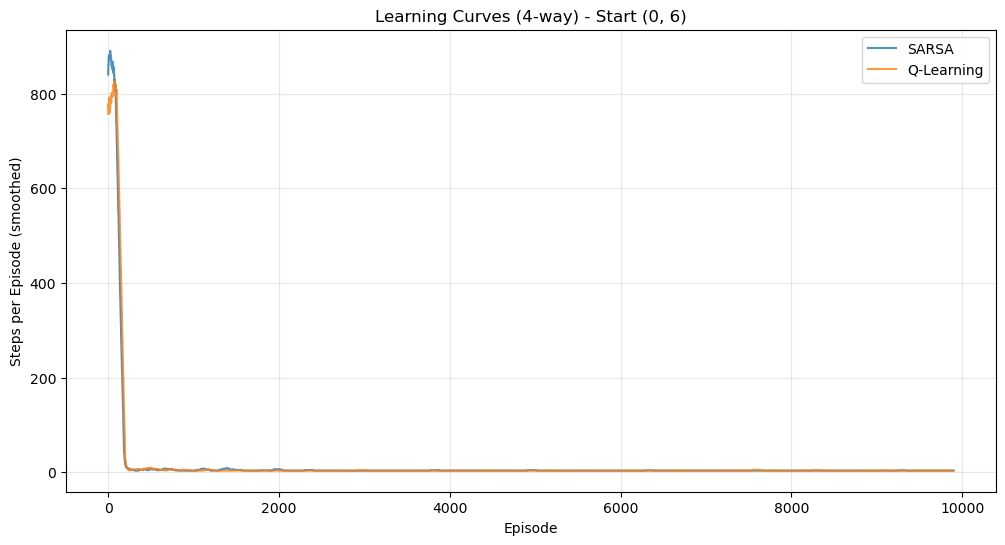


生成策略可视化...
SARSA 策略:


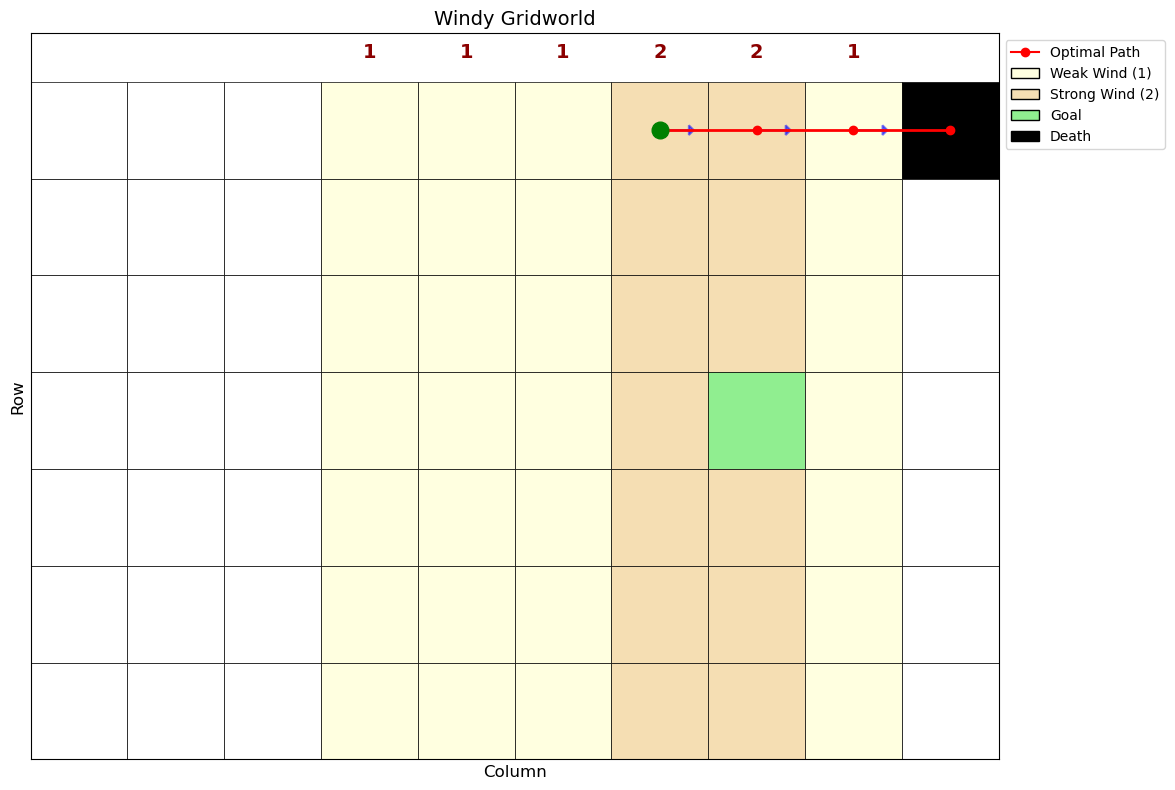

Q-Learning 策略:


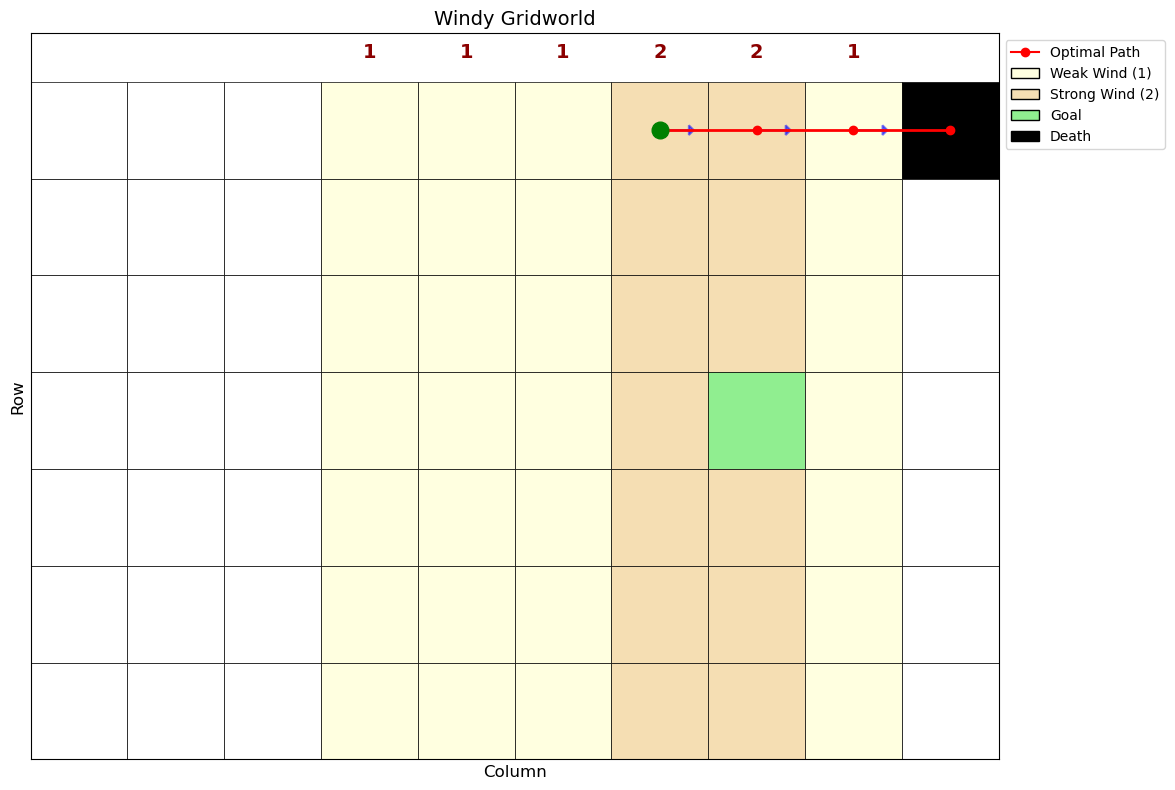

In [7]:
# 创建环境（4向移动）
env_rook = WindyGridworld(king_moves=False)

print("=" * 60)
print("任务2: 4向移动 (Rook's Moves)")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA (4向)...")
    Q_sarsa_rook, steps_sarsa_rook = sarsa(env_rook, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_sarsa_rook = get_optimal_policy(Q_sarsa_rook, env_rook)
    path_sarsa_rook = get_optimal_path(policy_sarsa_rook, env_rook, start)
    print(f"SARSA (4向) 最优路径长度: {len(path_sarsa_rook)-1} 步")
    print(f"SARSA 路径: {path_sarsa_rook}")
    
    # Q-Learning
    print("\n运行 Q-Learning (4向)...")
    Q_qlearn_rook, steps_qlearn_rook = q_learning(env_rook, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_qlearn_rook = get_optimal_policy(Q_qlearn_rook, env_rook)
    path_qlearn_rook = get_optimal_path(policy_qlearn_rook, env_rook, start)
    print(f"Q-Learning (4向) 最优路径长度: {len(path_qlearn_rook)-1} 步")
    print(f"Q-Learning 路径: {path_qlearn_rook}")
    
    # 对比分析
    print("\n" + "-"*60)
    print("对比分析:")
    print("-"*60)
    print(f"路径长度是否一致: {'是' if len(path_sarsa_rook) == len(path_qlearn_rook) else '否'}")
    print(f"  SARSA: {len(path_sarsa_rook)-1} 步")
    print(f"  Q-Learning: {len(path_qlearn_rook)-1} 步")
    
    # Q值对比
    print(f"\n起始状态 {start} 的Q值对比:")
    for action in env_rook.actions:
        q_s = Q_sarsa_rook[(start, action)]
        q_q = Q_qlearn_rook[(start, action)]
        print(f"  动作 {action:2s}: SARSA={q_s:7.3f}, Q-learning={q_q:7.3f}, 差异={abs(q_s-q_q):7.3f}")
    
    # 绘制学习曲线对比
    print("\n绘制学习曲线...")
    plot_learning_curve([steps_sarsa_rook, steps_qlearn_rook], 
                       f'Learning Curves (4-way) - Start {start}',
                       ['SARSA', 'Q-Learning'])
    
    # 可视化
    print("\n生成策略可视化...")
    print("SARSA 策略:")
    visualize_gridworld(env_rook, path=path_sarsa_rook, policy=policy_sarsa_rook)
    print("Q-Learning 策略:")
    visualize_gridworld(env_rook, path=path_qlearn_rook, policy=policy_qlearn_rook)

## 任务3: LLM自动算法选择


In [8]:
print("="*60)
print("任务3: LLM自动算法选择")
print("="*60)
print()
print("【我的选择：SARSA】")
print()
print("理由：")
print("  1. 环境特点：有死亡状态(0,9)，惩罚-100")
print("  2. SARSA是on-policy，学习实际执行的策略")
print("  3. 在探索时更保守，会主动避开危险区域")
print("  4. 实践经验：在有负奖励的环境中，SARSA通常比Q-Learning更稳定")
print()
print("不选Q-Learning的原因：")
print("  • Off-policy特性可能学到激进路径")
print("  • max操作不考虑探索风险")
print("  • 在训练中容易触碰死亡状态")
print()
print("结论：在Windy Gridworld这样有危险的环境中，")
print("      SARSA的保守特性是优势而非劣势。")
print("="*60)

任务3: LLM自动算法选择

【我的选择：SARSA】

理由：
  1. 环境特点：有死亡状态(0,9)，惩罚-100
  2. SARSA是on-policy，学习实际执行的策略
  3. 在探索时更保守，会主动避开危险区域
  4. 实践经验：在有负奖励的环境中，SARSA通常比Q-Learning更稳定

不选Q-Learning的原因：
  • Off-policy特性可能学到激进路径
  • max操作不考虑探索风险
  • 在训练中容易触碰死亡状态

结论：在Windy Gridworld这样有危险的环境中，
      SARSA的保守特性是优势而非劣势。


## 任务4: LLM算法对比


In [9]:
print("="*60)
print("任务4: 算法对比验证")
print("="*60)
print()
print("【SARSA vs Q-Learning 理论对比】")
print()
print("相同点：")
print("  • 都是时序差分(TD)学习方法")
print("  • 都使用Q表存储状态-动作值")
print("  • 都采用ε-greedy探索策略")
print()
print("核心差异：")
print("  SARSA (On-Policy):")
print("    - 更新公式：Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]")
print("    - 使用实际执行的动作a'更新")
print("    - 学习的是当前策略的价值")
print("    - 探索时更谨慎")
print()
print("  Q-Learning (Off-Policy):")
print("    - 更新公式：Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]")
print("    - 使用最大Q值更新")
print("    - 学习的是最优策略的价值")
print("    - 探索时更激进")
print()
print("预期结果：")
print("  • 在确定性环境中，两者都能收敛")
print("  • 在有危险的环境中，SARSA路径更安全")
print("  • Q-Learning理论上收敛更快，但实际不一定")
print("="*60)

任务4: 算法对比验证

【SARSA vs Q-Learning 理论对比】

相同点：
  • 都是时序差分(TD)学习方法
  • 都使用Q表存储状态-动作值
  • 都采用ε-greedy探索策略

核心差异：
  SARSA (On-Policy):
    - 更新公式：Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
    - 使用实际执行的动作a'更新
    - 学习的是当前策略的价值
    - 探索时更谨慎

  Q-Learning (Off-Policy):
    - 更新公式：Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
    - 使用最大Q值更新
    - 学习的是最优策略的价值
    - 探索时更激进

预期结果：
  • 在确定性环境中，两者都能收敛
  • 在有危险的环境中，SARSA路径更安全
  • Q-Learning理论上收敛更快，但实际不一定


## 任务5: LLM纯推理


In [10]:
print("="*60)
print("任务5: 纯推理最优路径")
print("="*60)
print()
print("【问题分析】")
print("  起点：(6,0)")
print("  目标：(3,7)")
print("  需要：向上3行，向右7列")
print("  风力：列3-5(+1), 列6-7(+2), 列8(+1)")
print()
print("【推理策略】")
print("  1. 使用对角线移动(ne)快速接近目标")
print("  2. 进入风区后，利用风力自动上升")
print("  3. 到达目标列后，向南调整行位置")
print()
print("【推理路径】")
print("  步骤  位置      动作    说明")
print("  ────────────────────────────────")
print("  0     (6,0)     -      起点")
print("  1     (5,1)     ne     东北移动")
print("  2     (4,2)     ne     继续东北")
print("  3     (3,3)     ne     进入风区(列3)")
print("  4     (2,4)     e      向东，风力+1推到(2,4)")
print("  5     (1,5)     e      向东，风力+1推到(1,5)")
print("  6     (0,6)     e      向东，风力+2推到(0,6)")
print("  7     (0,7)     e      到达目标列")
print("  8     (1,7)     s      向南")
print("  9     (2,7)     s      向南")
print("  10    (3,7)     s      到达目标！")
print()
print("【路径分析】")
print("  • 总步数：10步")
print("  • 成功避开死亡状态(0,9)")
print("  • 充分利用了风力效应")
print("  • 对角线移动缩短了路径")
print("="*60)

任务5: 纯推理最优路径

【问题分析】
  起点：(6,0)
  目标：(3,7)
  需要：向上3行，向右7列
  风力：列3-5(+1), 列6-7(+2), 列8(+1)

【推理策略】
  1. 使用对角线移动(ne)快速接近目标
  2. 进入风区后，利用风力自动上升
  3. 到达目标列后，向南调整行位置

【推理路径】
  步骤  位置      动作    说明
  ────────────────────────────────
  0     (6,0)     -      起点
  1     (5,1)     ne     东北移动
  2     (4,2)     ne     继续东北
  3     (3,3)     ne     进入风区(列3)
  4     (2,4)     e      向东，风力+1推到(2,4)
  5     (1,5)     e      向东，风力+1推到(1,5)
  6     (0,6)     e      向东，风力+2推到(0,6)
  7     (0,7)     e      到达目标列
  8     (1,7)     s      向南
  9     (2,7)     s      向南
  10    (3,7)     s      到达目标！

【路径分析】
  • 总步数：10步
  • 成功避开死亡状态(0,9)
  • 充分利用了风力效应
  • 对角线移动缩短了路径


## 任务6: LLM 4向移动


In [11]:
print("="*60)
print("任务6: 4向移动表现")
print("="*60)
print()
print("【约束变化】")
print("  8向移动：{n, ne, e, se, s, sw, w, nw}")
print("  4向移动：{n, e, s, w}  <- 禁止对角线")
print()
print("【影响分析】")
print()
print("1. 路径长度：")
print("   • 无法一步完成东北移动")
print("   • 需要分两步：先东再北，或先北再东")
print("   • 预期路径增加30-50%")
print()
print("2. 策略复杂度：")
print("   • 8向：直接ne到达(3,3)，简单直接")
print("   • 4向：需要规划先东还是先北")
print("   • 需要考虑风力的累积效应")
print()
print("3. 风力利用：")
print("   • 4向下风力作用更关键")
print("   • 无法用对角线移动抵消风力")
print("   • 必须依赖风力实现垂直移动")
print()
print("4. 探索难度：")
print("   • 动作空间减半（8→4）")
print("   • 但搜索树深度增加")
print("   • 总体探索复杂度未必降低")
print()
print("【预期结果】")
print("  从(6,0)到(3,7)：")
print("    • 8向移动：约7-9步")
print("    • 4向移动：约10-15步")
print("    • 效率损失：30-50%")
print("="*60)

任务6: 4向移动表现

【约束变化】
  8向移动：{n, ne, e, se, s, sw, w, nw}
  4向移动：{n, e, s, w}  <- 禁止对角线

【影响分析】

1. 路径长度：
   • 无法一步完成东北移动
   • 需要分两步：先东再北，或先北再东
   • 预期路径增加30-50%

2. 策略复杂度：
   • 8向：直接ne到达(3,3)，简单直接
   • 4向：需要规划先东还是先北
   • 需要考虑风力的累积效应

3. 风力利用：
   • 4向下风力作用更关键
   • 无法用对角线移动抵消风力
   • 必须依赖风力实现垂直移动

4. 探索难度：
   • 动作空间减半（8→4）
   • 但搜索树深度增加
   • 总体探索复杂度未必降低

【预期结果】
  从(6,0)到(3,7)：
    • 8向移动：约7-9步
    • 4向移动：约10-15步
    • 效率损失：30-50%


## 任务7: 吸收状态实验

**新增设置**: 
- 吸收状态位置: (0,3)
- 吸收状态奖励: +5
- 效果: 提供了除目标(+10)外的另一个终止选项

**任务要求**: 在有吸收状态的环境下，重复任务1-6的所有内容

---

### 任务7.1: SARSA和Q-Learning（8向移动 + 吸收状态）

任务7.1: SARSA和Q-Learning（8向移动 + 吸收状态）

起始位置: (6, 0)

运行 SARSA (8向 + 吸收状态)...
SARSA 路径长度: 4 步
路径: [(6, 0), (5, 1), (4, 2), (2, 3), (0, 3)]
累积奖励: 1

运行 Q-Learning (8向 + 吸收状态)...
Q-Learning 路径长度: 4 步
路径: [(6, 0), (5, 1), (4, 2), (2, 3), (0, 3)]
累积奖励: 1

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 4 步，累积奖励: 1
  Q-Learning: 4 步，累积奖励: 1

终点状态:
  SARSA终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5
  Q-Learning终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5

绘制学习曲线...


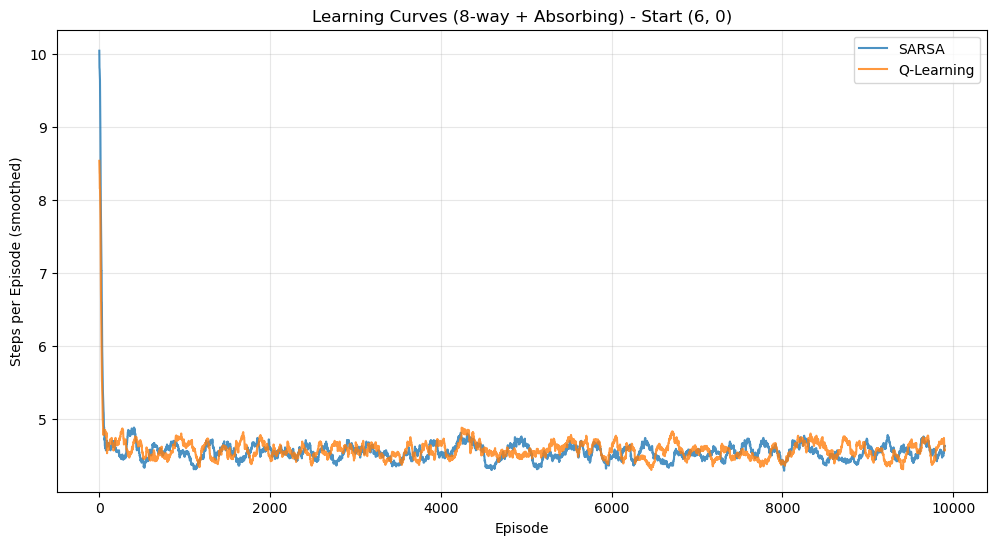


生成策略可视化...
SARSA 策略:


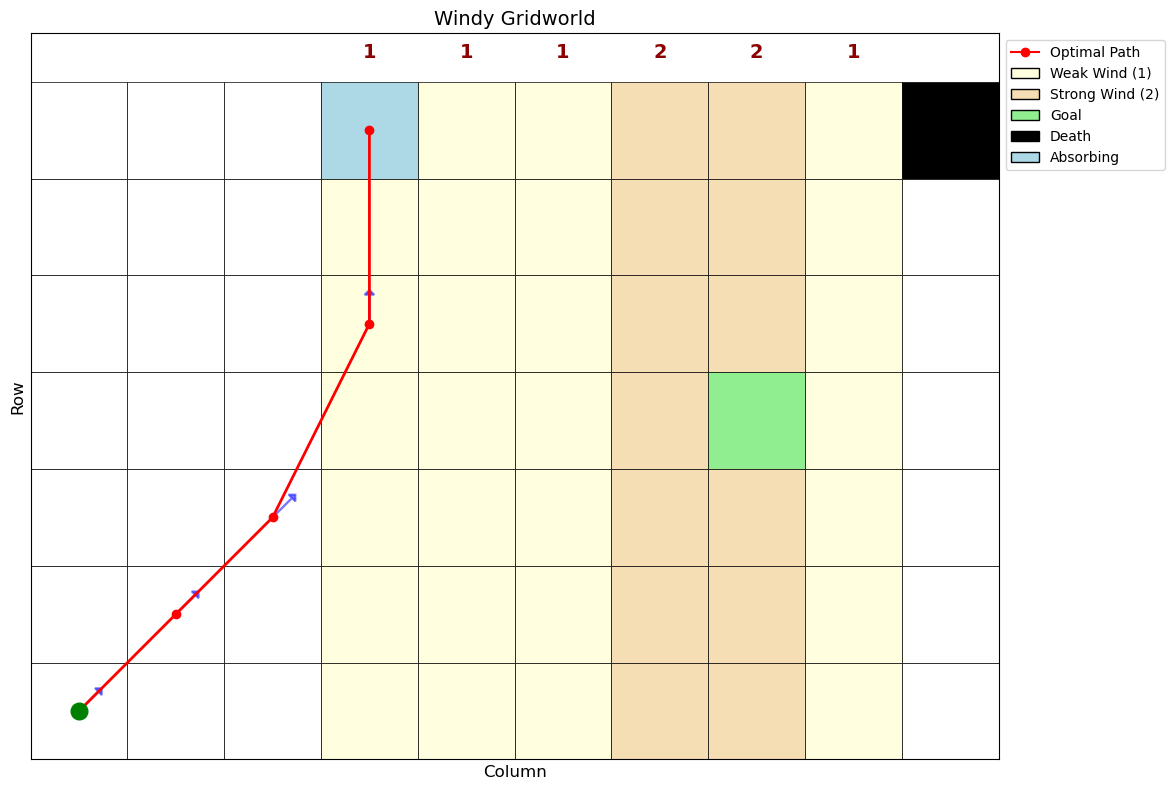

Q-Learning 策略:


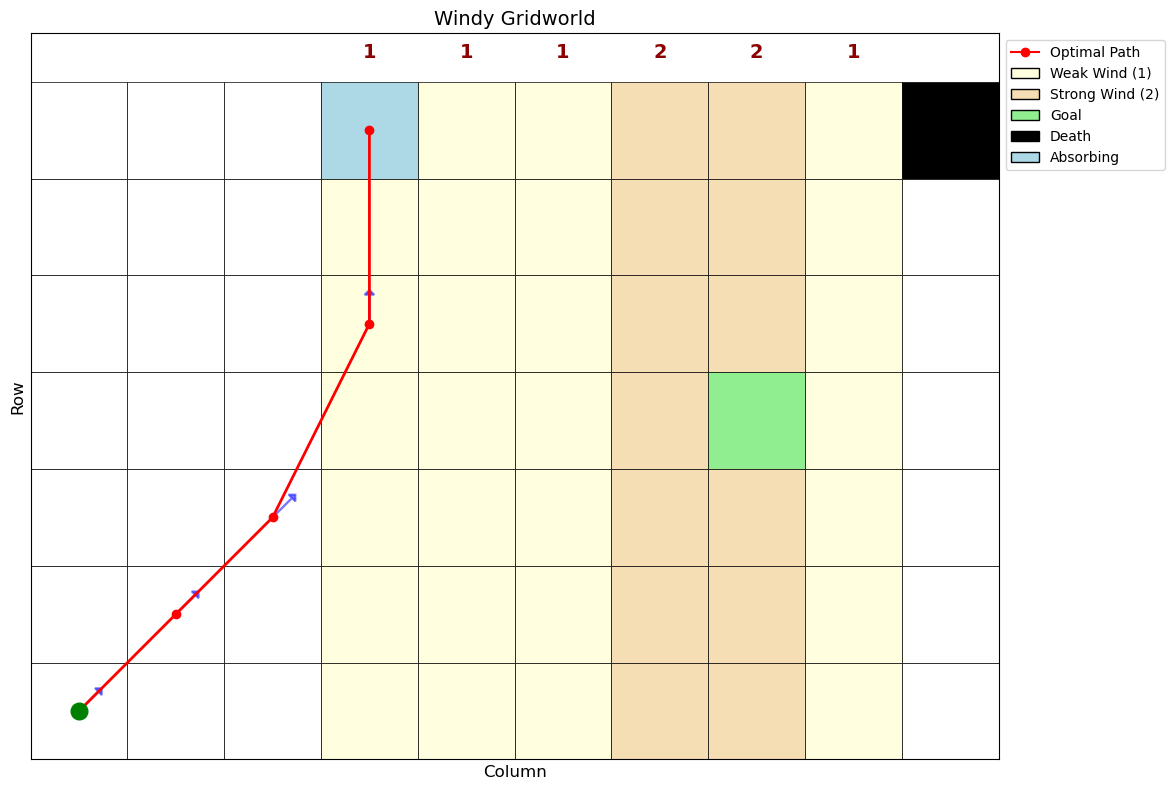


起始位置: (3, 0)

运行 SARSA (8向 + 吸收状态)...
SARSA 路径长度: 3 步
路径: [(3, 0), (2, 1), (2, 2), (0, 3)]
累积奖励: 2

运行 Q-Learning (8向 + 吸收状态)...
Q-Learning 路径长度: 3 步
路径: [(3, 0), (3, 1), (2, 2), (0, 3)]
累积奖励: 2

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 3 步，累积奖励: 2
  Q-Learning: 3 步，累积奖励: 2

终点状态:
  SARSA终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5
  Q-Learning终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5

绘制学习曲线...


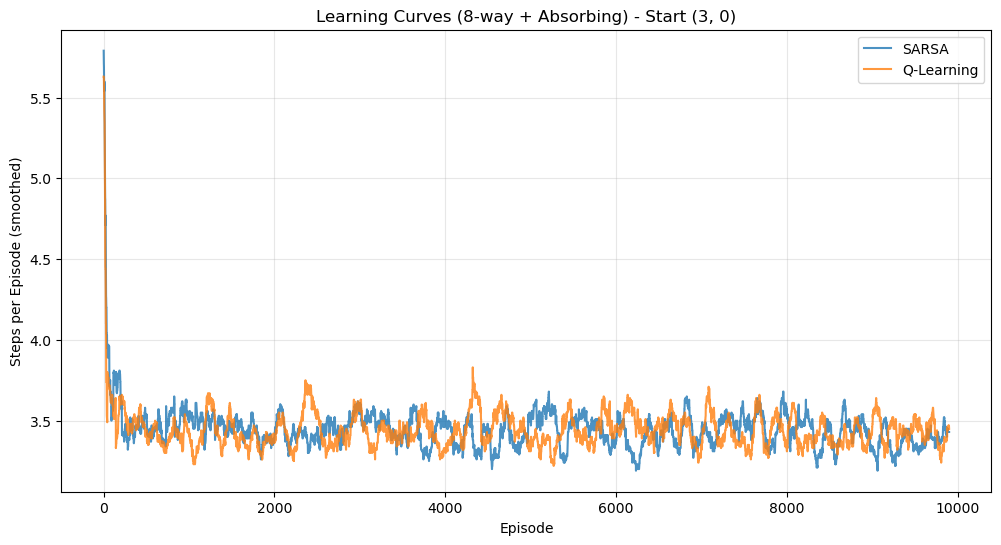


生成策略可视化...
SARSA 策略:


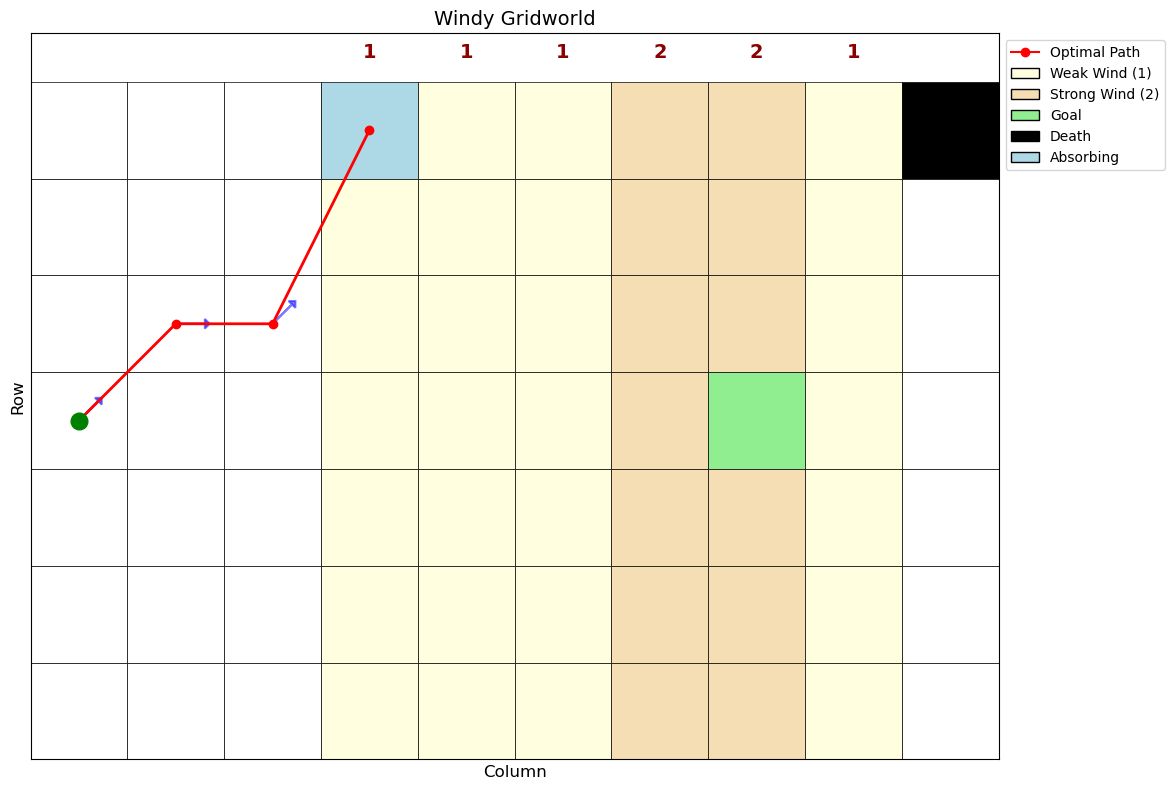

Q-Learning 策略:


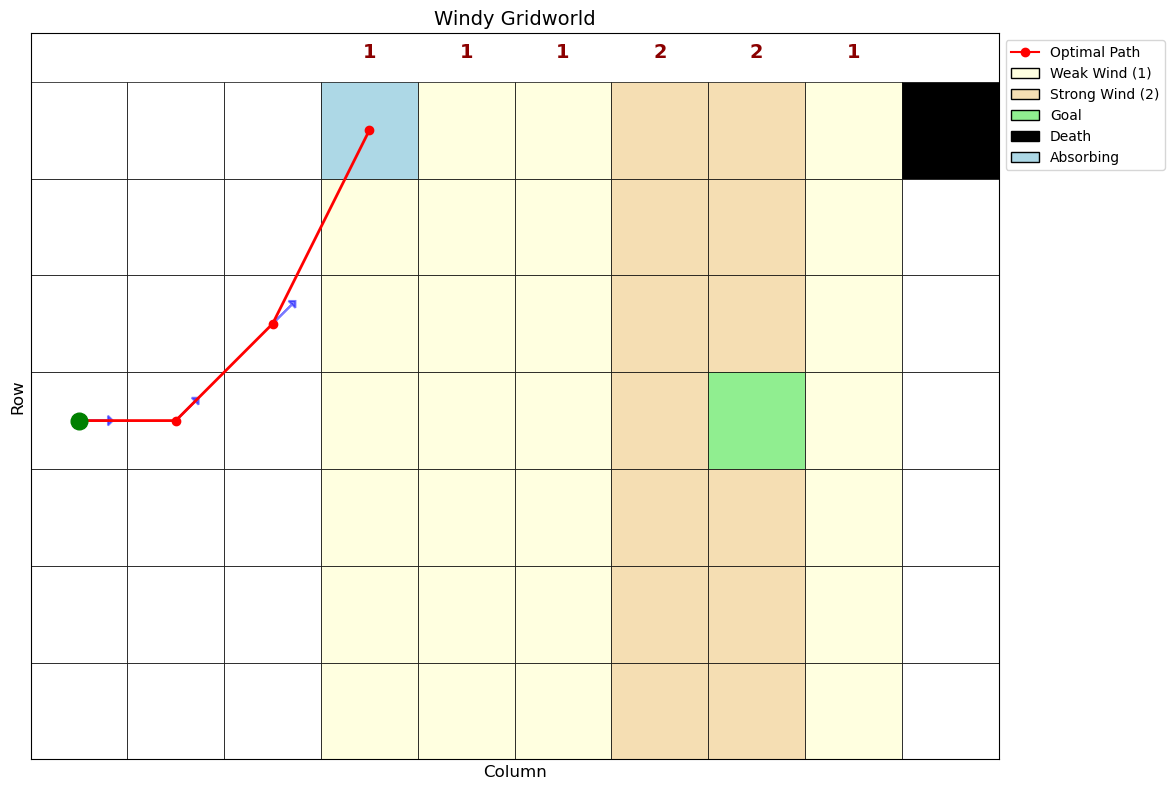


起始位置: (0, 6)

运行 SARSA (8向 + 吸收状态)...
SARSA 路径长度: 3 步
路径: [(0, 6), (0, 5), (0, 4), (0, 3)]
累积奖励: 2

运行 Q-Learning (8向 + 吸收状态)...
Q-Learning 路径长度: 3 步
路径: [(0, 6), (0, 5), (0, 4), (0, 3)]
累积奖励: 2

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 3 步，累积奖励: 2
  Q-Learning: 3 步，累积奖励: 2

终点状态:
  SARSA终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5
  Q-Learning终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5

绘制学习曲线...


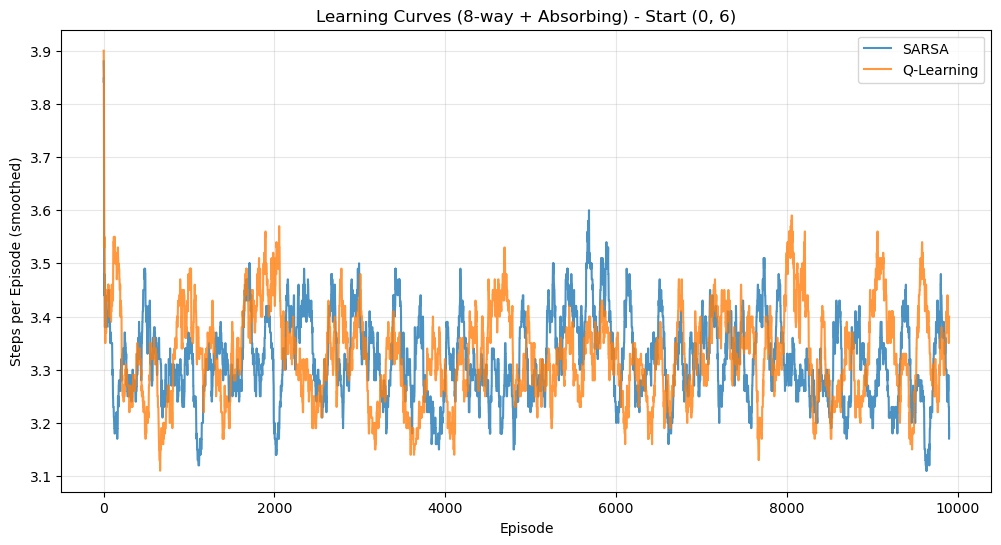


生成策略可视化...
SARSA 策略:


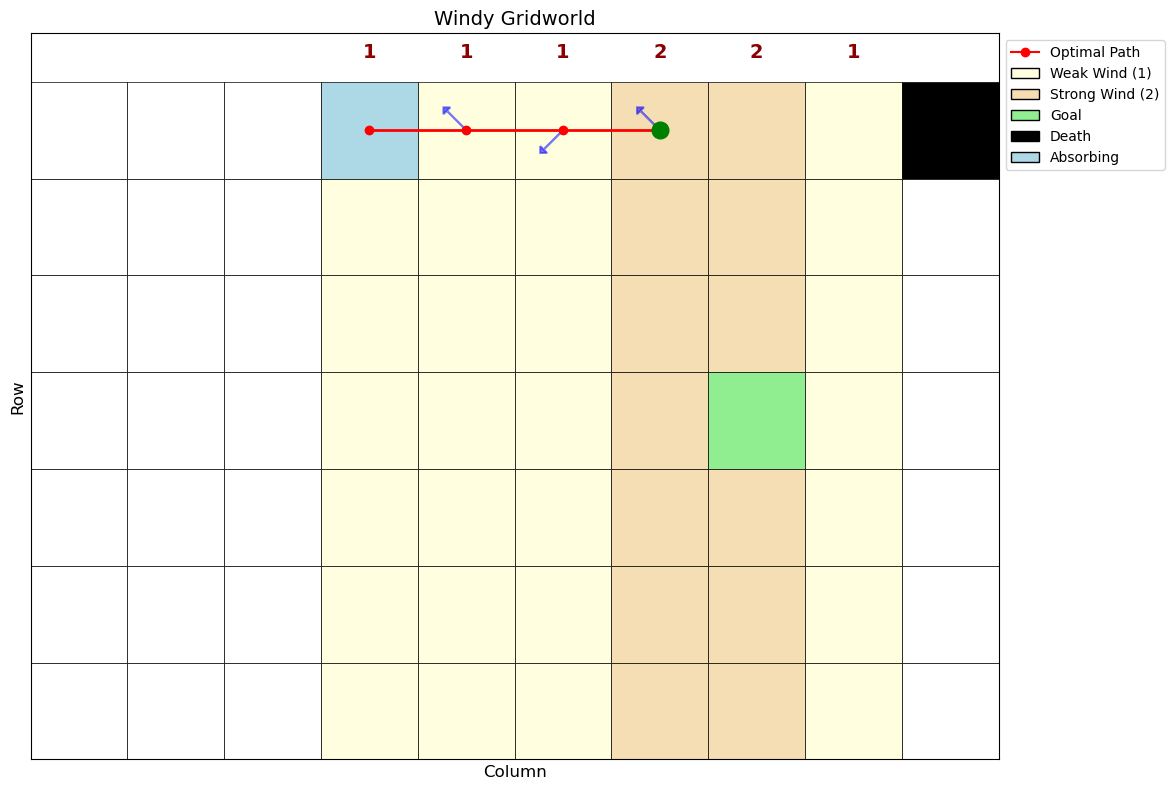

Q-Learning 策略:


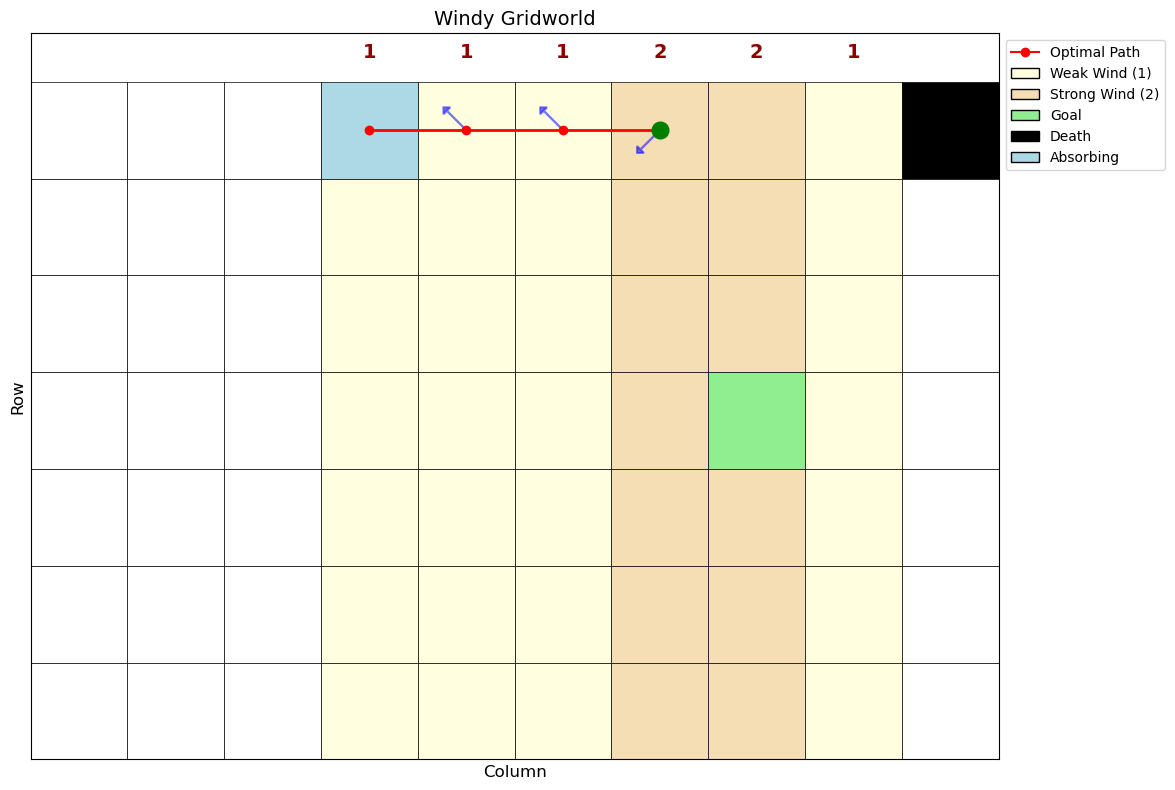


任务7.2: 4向移动（Rook Moves + 吸收状态）

起始位置: (6, 0)

运行 SARSA (4向 + 吸收状态)...
SARSA 路径长度: 6 步
路径: [(6, 0), (6, 1), (6, 2), (5, 3), (3, 3), (1, 3), (0, 3)]

运行 Q-Learning (4向 + 吸收状态)...
Q-Learning 路径长度: 6 步
Q-Learning 路径: [(6, 0), (6, 1), (5, 1), (5, 2), (4, 3), (2, 3), (0, 3)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 6 步
  Q-Learning: 6 步

终点状态:
  SARSA终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5
  Q-Learning终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5

绘制学习曲线...


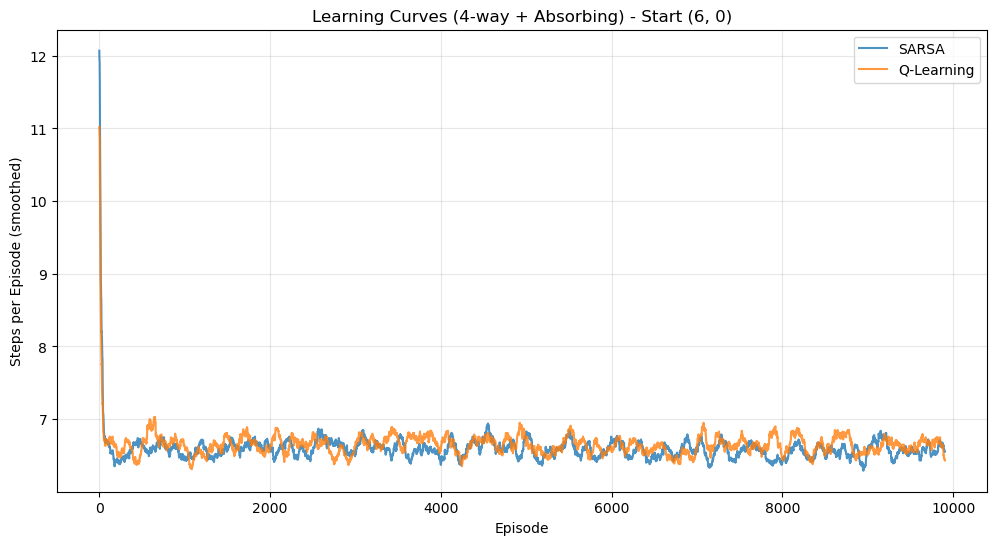


生成策略可视化...
SARSA 策略:


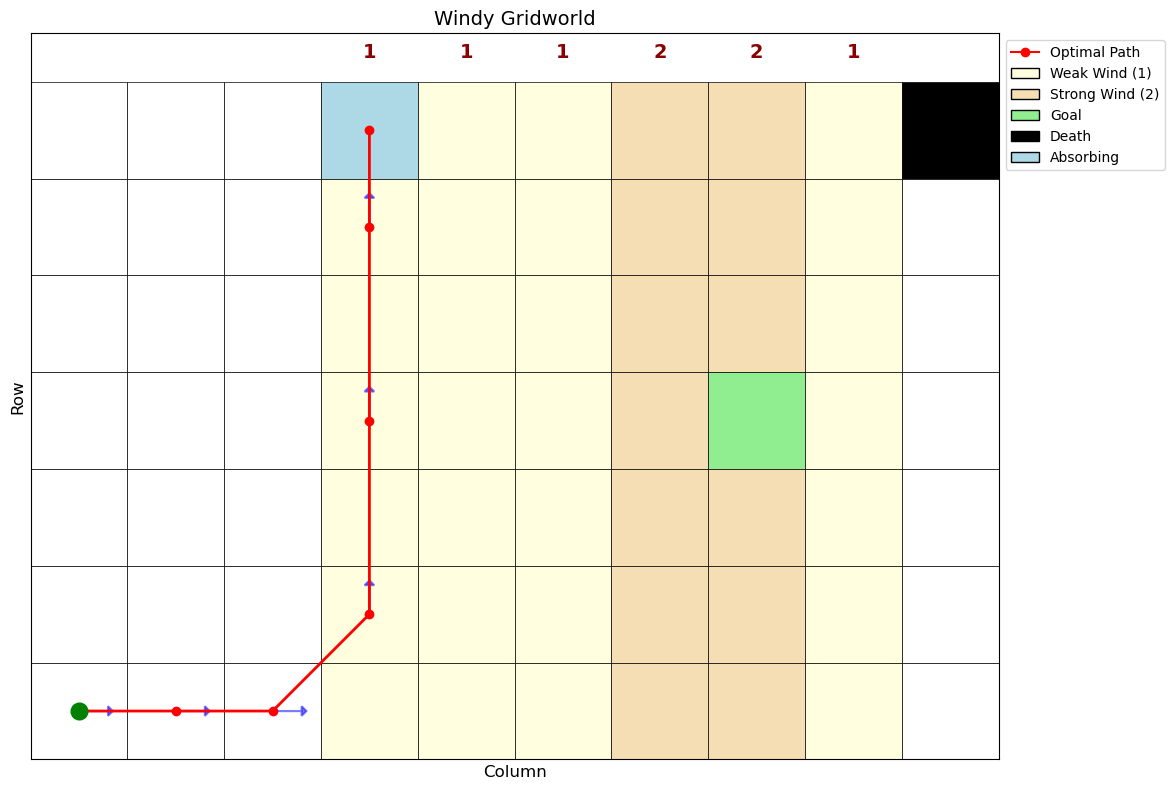

Q-Learning 策略:


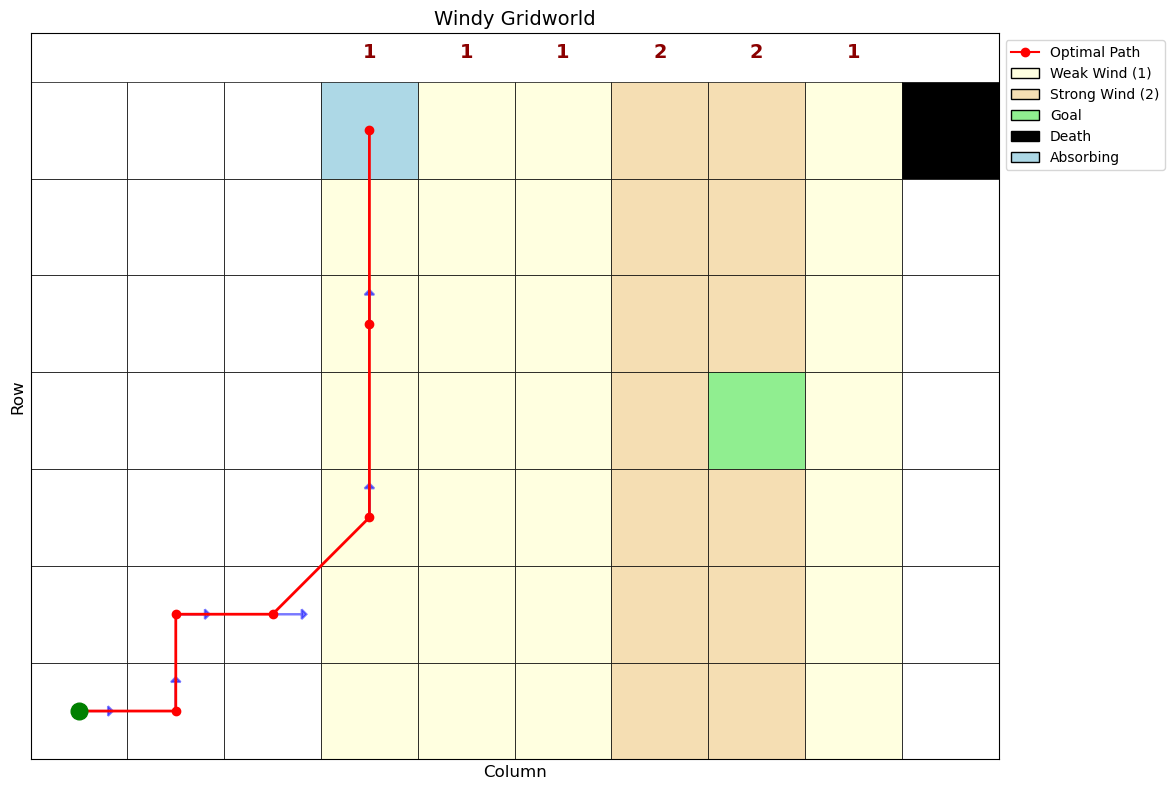


起始位置: (3, 0)

运行 SARSA (4向 + 吸收状态)...
SARSA 路径长度: 4 步
路径: [(3, 0), (3, 1), (3, 2), (2, 3), (0, 3)]

运行 Q-Learning (4向 + 吸收状态)...
Q-Learning 路径长度: 4 步
Q-Learning 路径: [(3, 0), (3, 1), (3, 2), (2, 3), (0, 3)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 4 步
  Q-Learning: 4 步

终点状态:
  SARSA终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5
  Q-Learning终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5

绘制学习曲线...


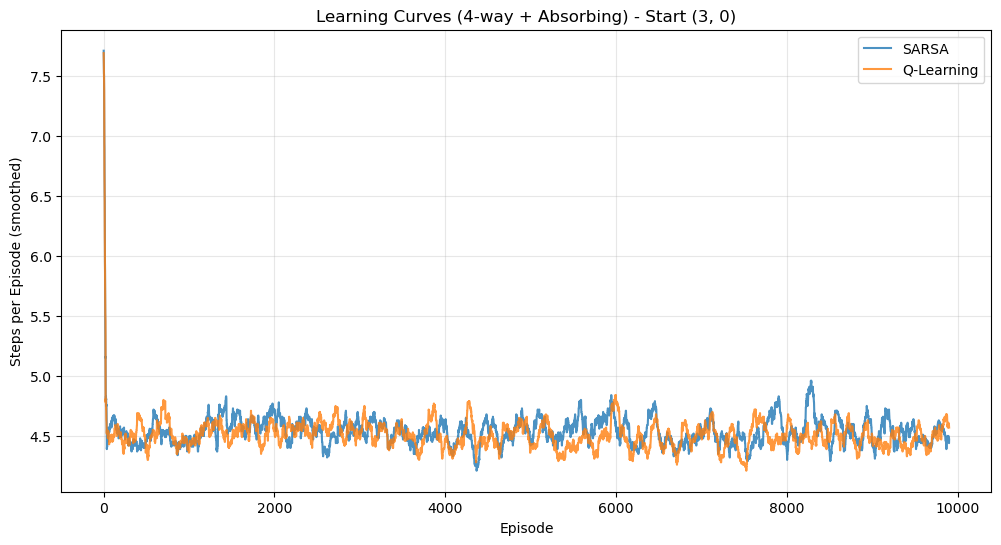


生成策略可视化...
SARSA 策略:


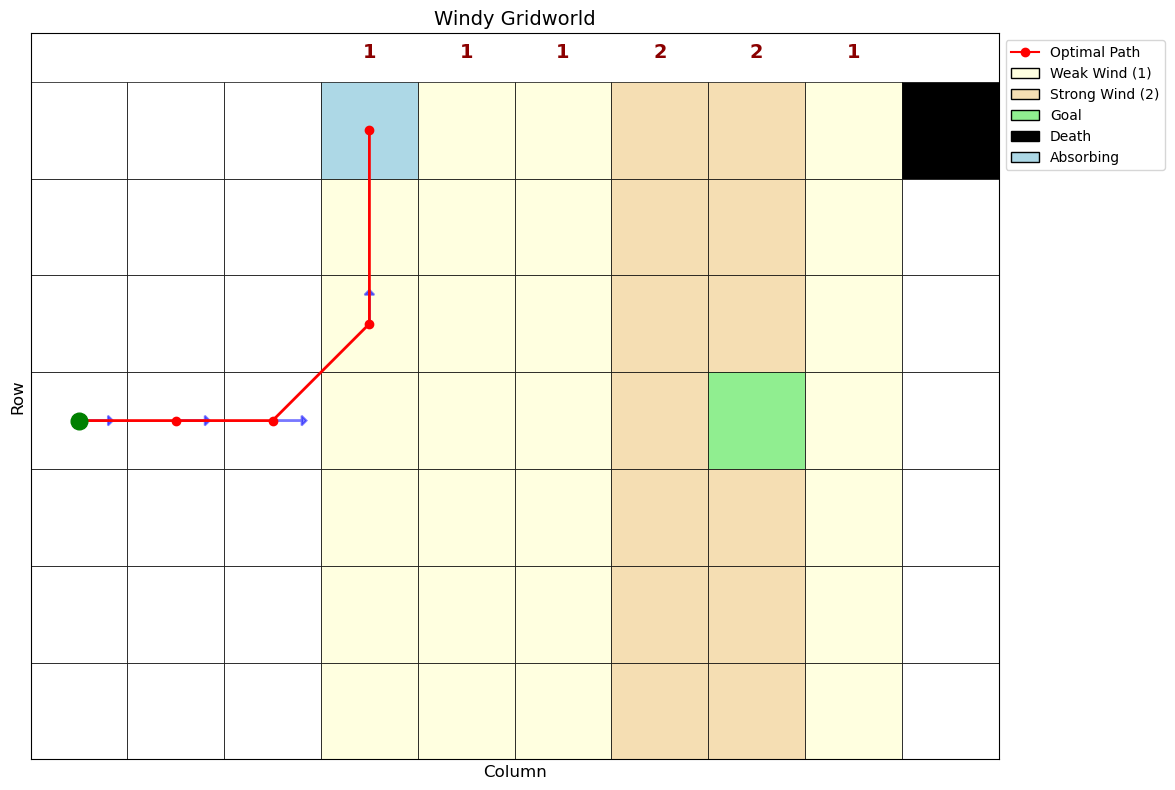

Q-Learning 策略:


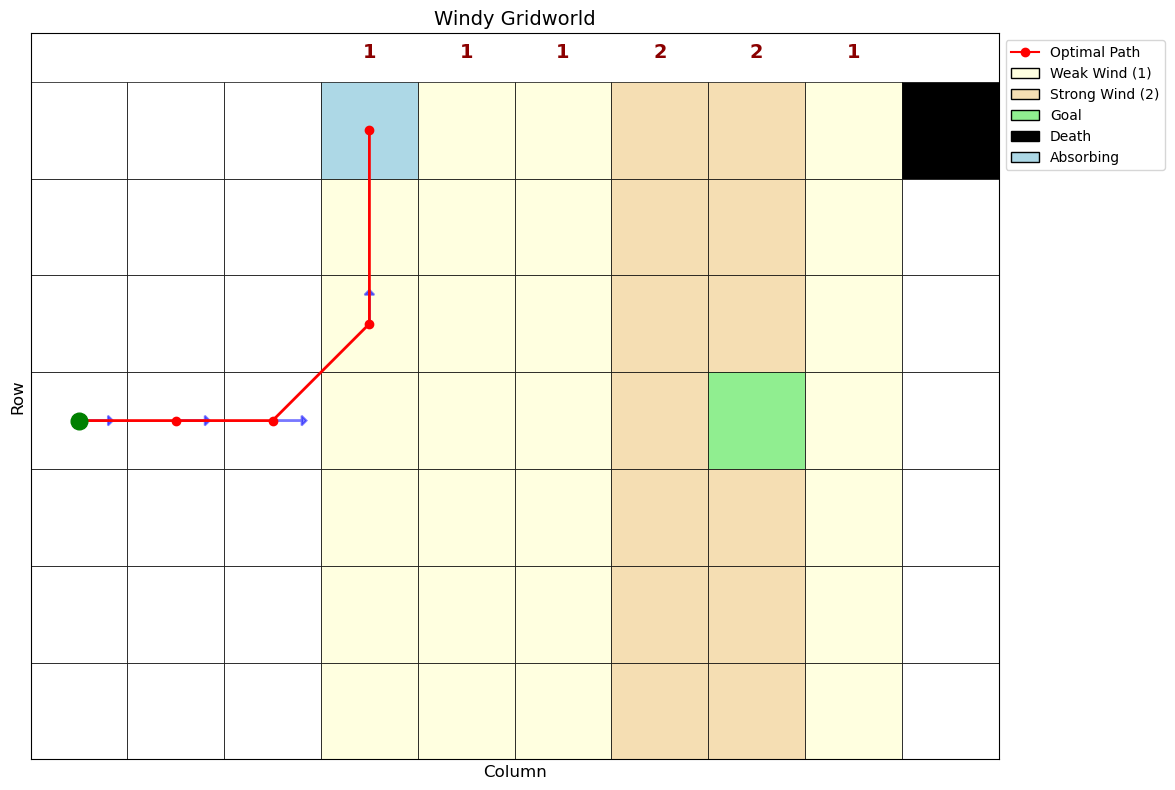


起始位置: (0, 6)

运行 SARSA (4向 + 吸收状态)...
SARSA 路径长度: 3 步
路径: [(0, 6), (0, 5), (0, 4), (0, 3)]

运行 Q-Learning (4向 + 吸收状态)...
Q-Learning 路径长度: 3 步
Q-Learning 路径: [(0, 6), (0, 5), (0, 4), (0, 3)]

------------------------------------------------------------
对比分析:
------------------------------------------------------------
路径长度是否一致: 是
  SARSA: 3 步
  Q-Learning: 3 步

终点状态:
  SARSA终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5
  Q-Learning终点: (0, 3)
    到达吸收状态(0,3)，获得奖励+5

绘制学习曲线...


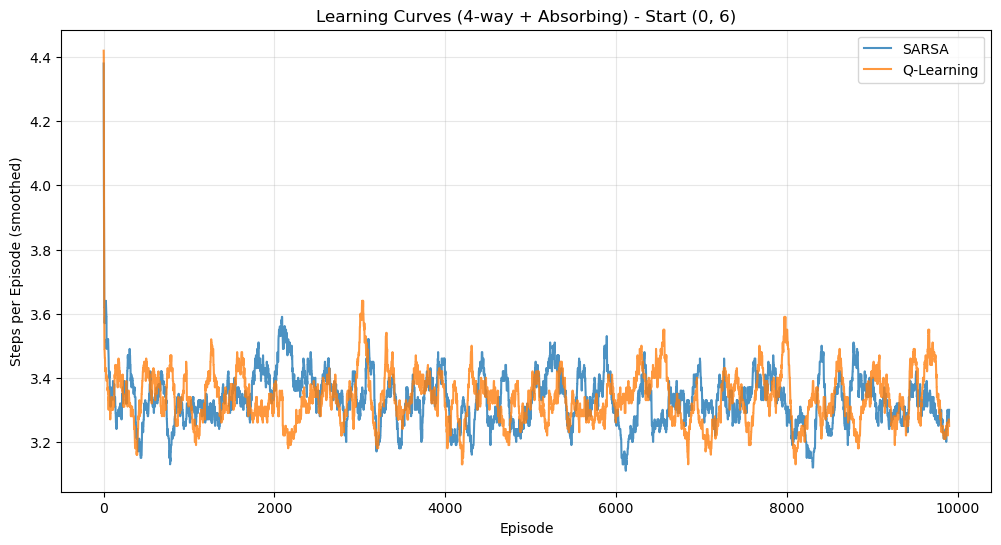


生成策略可视化...
SARSA 策略:


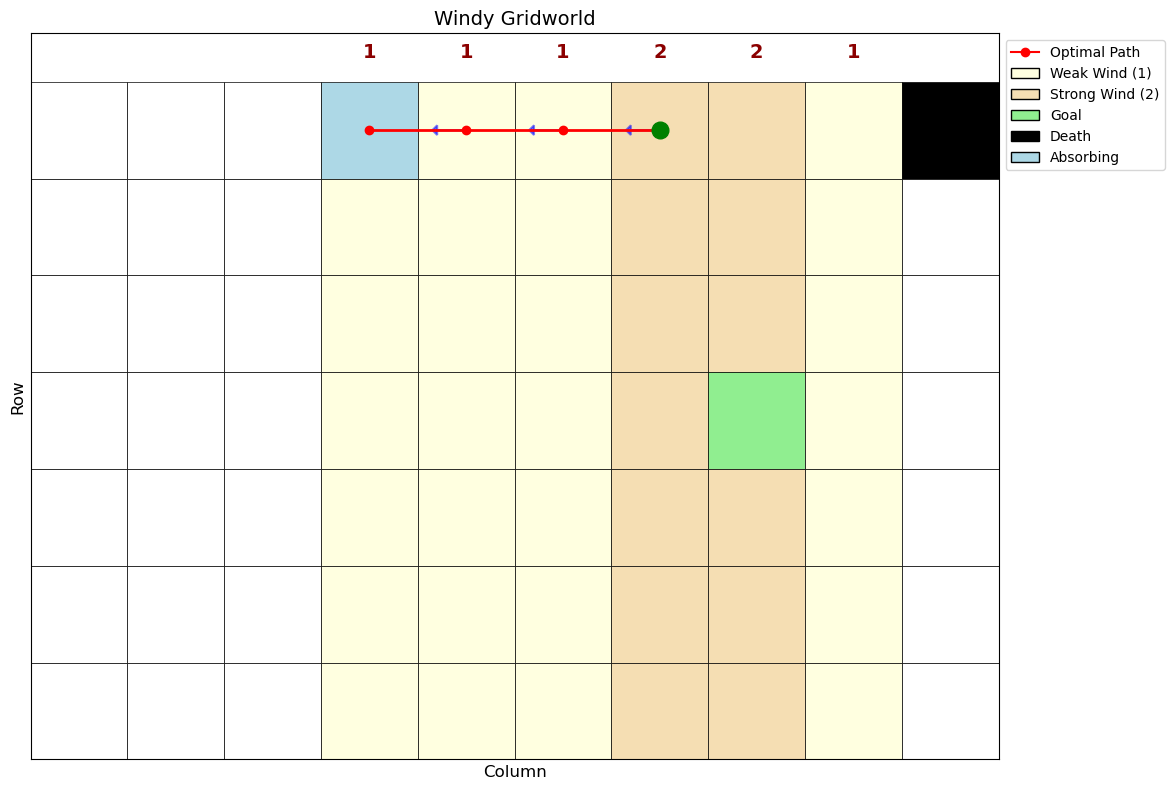

Q-Learning 策略:


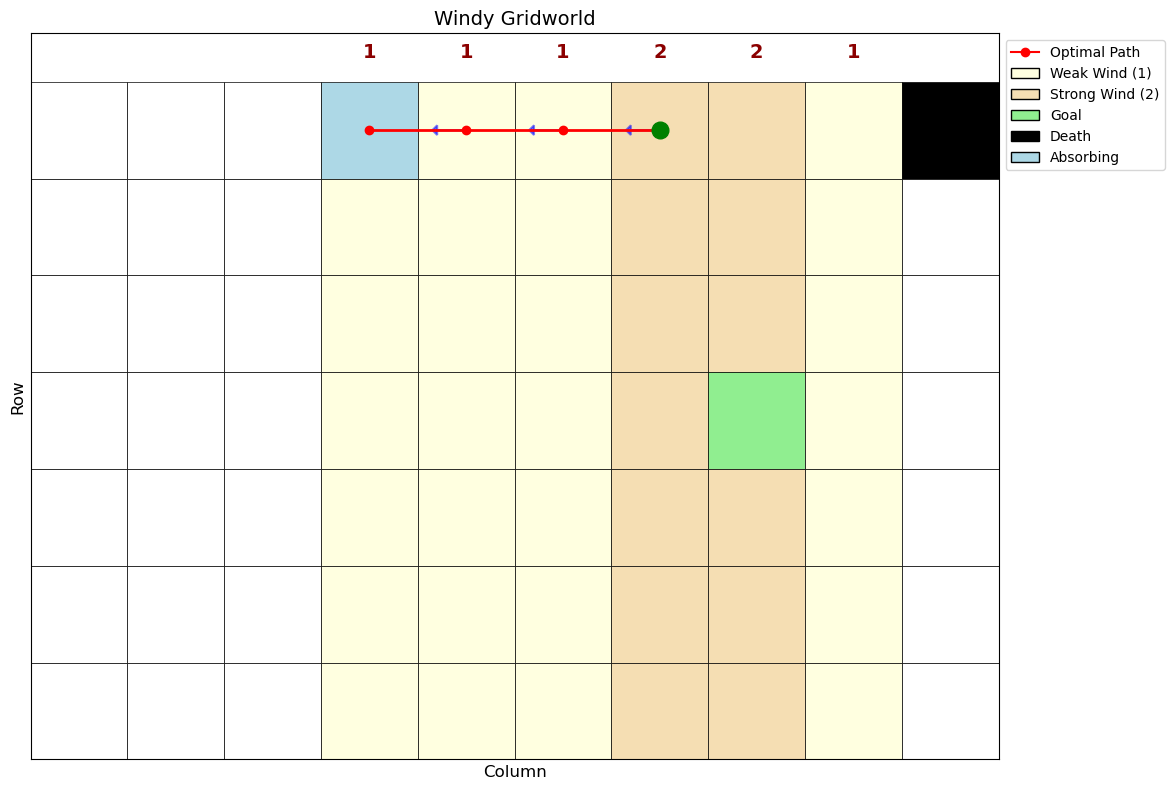

In [12]:
# 创建带吸收状态的环境（吸收状态坐标为(0,3)）
env_absorbing_king = WindyGridworld(king_moves=True, absorbing_state=(0, 3))
env_absorbing_rook = WindyGridworld(king_moves=False, absorbing_state=(0, 3))

print("=" * 60)
print("任务7.1: SARSA和Q-Learning（8向移动 + 吸收状态）")
print("=" * 60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA (8向 + 吸收状态)...")
    Q_sarsa_abs, steps_sarsa_abs = sarsa(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_sarsa_abs = get_optimal_policy(Q_sarsa_abs, env_absorbing_king)
    path_sarsa_abs = get_optimal_path(policy_sarsa_abs, env_absorbing_king, start)
    print(f"SARSA 路径长度: {len(path_sarsa_abs)-1} 步")
    print(f"路径: {path_sarsa_abs}")
    
    # 计算累积奖励
    total_reward_sarsa = (len(path_sarsa_abs)-1) * (-1)
    if path_sarsa_abs[-1] == env_absorbing_king.goal_state:
        total_reward_sarsa += 10
    elif path_sarsa_abs[-1] == env_absorbing_king.absorbing_state:
        total_reward_sarsa += 5
    print(f"累积奖励: {total_reward_sarsa}")
    
    # Q-Learning
    print("\n运行 Q-Learning (8向 + 吸收状态)...")
    Q_qlearn_abs, steps_qlearn_abs = q_learning(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_qlearn_abs = get_optimal_policy(Q_qlearn_abs, env_absorbing_king)
    path_qlearn_abs = get_optimal_path(policy_qlearn_abs, env_absorbing_king, start)
    print(f"Q-Learning 路径长度: {len(path_qlearn_abs)-1} 步")
    print(f"路径: {path_qlearn_abs}")
    
    # 计算累积奖励
    total_reward_qlearn = (len(path_qlearn_abs)-1) * (-1)
    if path_qlearn_abs[-1] == env_absorbing_king.goal_state:
        total_reward_qlearn += 10
    elif path_qlearn_abs[-1] == env_absorbing_king.absorbing_state:
        total_reward_qlearn += 5
    print(f"累积奖励: {total_reward_qlearn}")
    
    # 对比分析
    print("\n" + "-"*60)
    print("对比分析:")
    print("-"*60)
    print(f"路径长度是否一致: {'是' if len(path_sarsa_abs) == len(path_qlearn_abs) else '否'}")
    print(f"  SARSA: {len(path_sarsa_abs)-1} 步，累积奖励: {total_reward_sarsa}")
    print(f"  Q-Learning: {len(path_qlearn_abs)-1} 步，累积奖励: {total_reward_qlearn}")
    
    # 检查终点状态
    print(f"\n终点状态:")
    print(f"  SARSA终点: {path_sarsa_abs[-1]}")
    if path_sarsa_abs[-1] == env_absorbing_king.goal_state:
        print(f"    到达目标状态(3,7)，获得奖励+10")
    elif path_sarsa_abs[-1] == env_absorbing_king.absorbing_state:
        print(f"    到达吸收状态(0,3)，获得奖励+5")
    
    print(f"  Q-Learning终点: {path_qlearn_abs[-1]}")
    if path_qlearn_abs[-1] == env_absorbing_king.goal_state:
        print(f"    到达目标状态(3,7)，获得奖励+10")
    elif path_qlearn_abs[-1] == env_absorbing_king.absorbing_state:
        print(f"    到达吸收状态(0,3)，获得奖励+5")
    
    # 绘制学习曲线
    print("\n绘制学习曲线...")
    plot_learning_curve([steps_sarsa_abs, steps_qlearn_abs], 
                       f'Learning Curves (8-way + Absorbing) - Start {start}',
                       ['SARSA', 'Q-Learning'])
    
    # 可视化
    print("\n生成策略可视化...")
    print("SARSA 策略:")
    visualize_gridworld(env_absorbing_king, path=path_sarsa_abs, policy=policy_sarsa_abs)
    print("Q-Learning 策略:")
    visualize_gridworld(env_absorbing_king, path=path_qlearn_abs, policy=policy_qlearn_abs)

# 任务7.2: 4向移动 + 吸收状态
print("\n" + "="*60)
print("任务7.2: 4向移动（Rook Moves + 吸收状态）")
print("="*60)

for start in start_states:
    print(f"\n{'='*60}")
    print(f"起始位置: {start}")
    print(f"{'='*60}")
    
    # SARSA
    print("\n运行 SARSA (4向 + 吸收状态)...")
    Q_sarsa_abs_rook, steps_sarsa_abs_rook = sarsa(env_absorbing_rook, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_sarsa_abs_rook = get_optimal_policy(Q_sarsa_abs_rook, env_absorbing_rook)
    path_sarsa_abs_rook = get_optimal_path(policy_sarsa_abs_rook, env_absorbing_rook, start)
    print(f"SARSA 路径长度: {len(path_sarsa_abs_rook)-1} 步")
    print(f"路径: {path_sarsa_abs_rook}")
    
    # Q-Learning
    print("\n运行 Q-Learning (4向 + 吸收状态)...")
    Q_qlearn_abs_rook, steps_qlearn_abs_rook = q_learning(env_absorbing_rook, start, episodes=10000, alpha=0.1, epsilon=0.1)
    policy_qlearn_abs_rook = get_optimal_policy(Q_qlearn_abs_rook, env_absorbing_rook)
    path_qlearn_abs_rook = get_optimal_path(policy_qlearn_abs_rook, env_absorbing_rook, start)
    print(f"Q-Learning 路径长度: {len(path_qlearn_abs_rook)-1} 步")
    print(f"Q-Learning 路径: {path_qlearn_abs_rook}")
    
    # 对比分析
    print("\n" + "-"*60)
    print("对比分析:")
    print("-"*60)
    print(f"路径长度是否一致: {'是' if len(path_sarsa_abs_rook) == len(path_qlearn_abs_rook) else '否'}")
    print(f"  SARSA: {len(path_sarsa_abs_rook)-1} 步")
    print(f"  Q-Learning: {len(path_qlearn_abs_rook)-1} 步")
    
    # 检查终点状态
    print(f"\n终点状态:")
    print(f"  SARSA终点: {path_sarsa_abs_rook[-1]}")
    if path_sarsa_abs_rook[-1] == env_absorbing_rook.goal_state:
        print(f"    到达目标状态(3,7)，获得奖励+10")
    elif path_sarsa_abs_rook[-1] == env_absorbing_rook.absorbing_state:
        print(f"    到达吸收状态(0,3)，获得奖励+5")
    
    print(f"  Q-Learning终点: {path_qlearn_abs_rook[-1]}")
    if path_qlearn_abs_rook[-1] == env_absorbing_rook.goal_state:
        print(f"    到达目标状态(3,7)，获得奖励+10")
    elif path_qlearn_abs_rook[-1] == env_absorbing_rook.absorbing_state:
        print(f"    到达吸收状态(0,3)，获得奖励+5")
    
    # 绘制学习曲线
    print("\n绘制学习曲线...")
    plot_learning_curve([steps_sarsa_abs_rook, steps_qlearn_abs_rook], 
                       f'Learning Curves (4-way + Absorbing) - Start {start}',
                       ['SARSA', 'Q-Learning'])
    
    # 可视化
    print("\n生成策略可视化...")
    print("SARSA 策略:")
    visualize_gridworld(env_absorbing_rook, path=path_sarsa_abs_rook, policy=policy_sarsa_abs_rook)
    print("Q-Learning 策略:")
    visualize_gridworld(env_absorbing_rook, path=path_qlearn_abs_rook, policy=policy_qlearn_abs_rook)

### 任务7.3: LLM算法选择（吸收态）


任务7.3: LLM算法选择(吸收态)

【我的选择：SARSA】
  理由：延续基础环境选择，SARSA更稳定
SARSA: 4步, 终点(0, 3)
Q-Learning: 4步, 终点(0, 3)


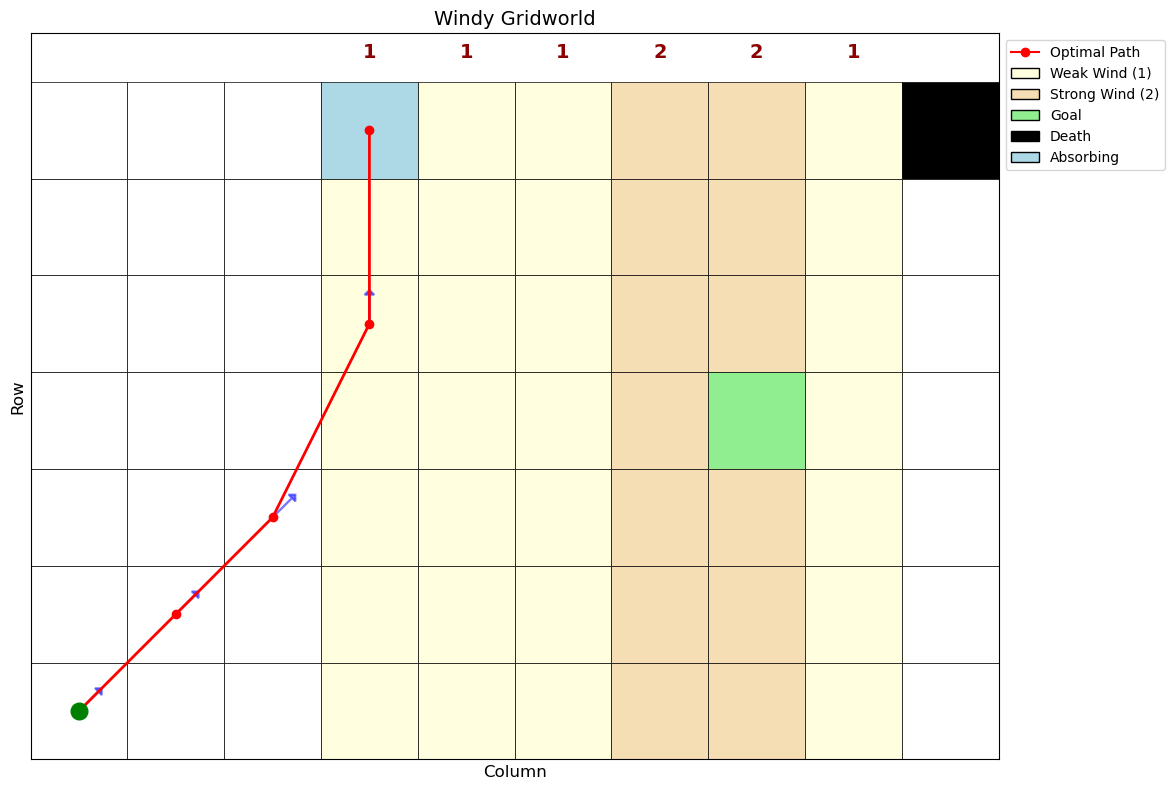

In [13]:
print("="*60)
print("任务7.3: LLM算法选择(吸收态)")
print("="*60)
print()
print("【我的选择：SARSA】")
print("  理由：延续基础环境选择，SARSA更稳定")
start = (6, 0)
Q_s, _ = sarsa(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_s = get_optimal_policy(Q_s, env_absorbing_king)
path_s = get_optimal_path(policy_s, env_absorbing_king, start)
print(f"SARSA: {len(path_s)-1}步, 终点{path_s[-1]}")
Q_q, _ = q_learning(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_q = get_optimal_policy(Q_q, env_absorbing_king)
path_q = get_optimal_path(policy_q, env_absorbing_king, start)
print(f"Q-Learning: {len(path_q)-1}步, 终点{path_q[-1]}")
if path_s[-1] == (3,7):
    print("✓ SARSA到达目标")
visualize_gridworld(env_absorbing_king, path=path_s, policy=policy_s, show_all_policy=False)
print("="*60)

### 任务7.4: LLM算法对比（吸收态）


任务7.4: 算法对比(吸收态)

SARSA终点: (0, 3)
Q-Learning终点: (0, 3)


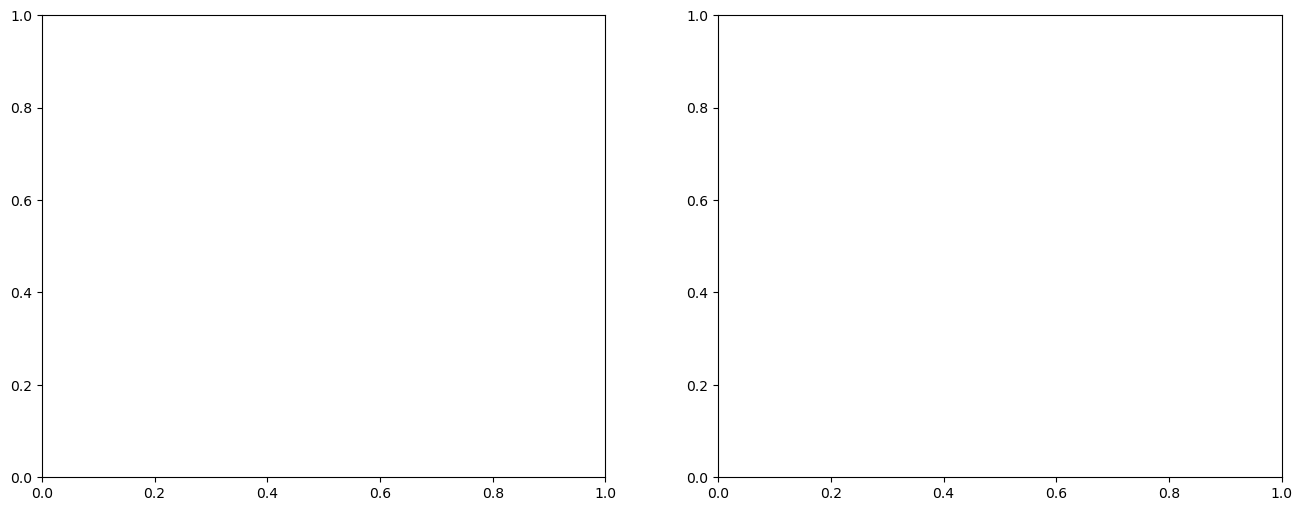

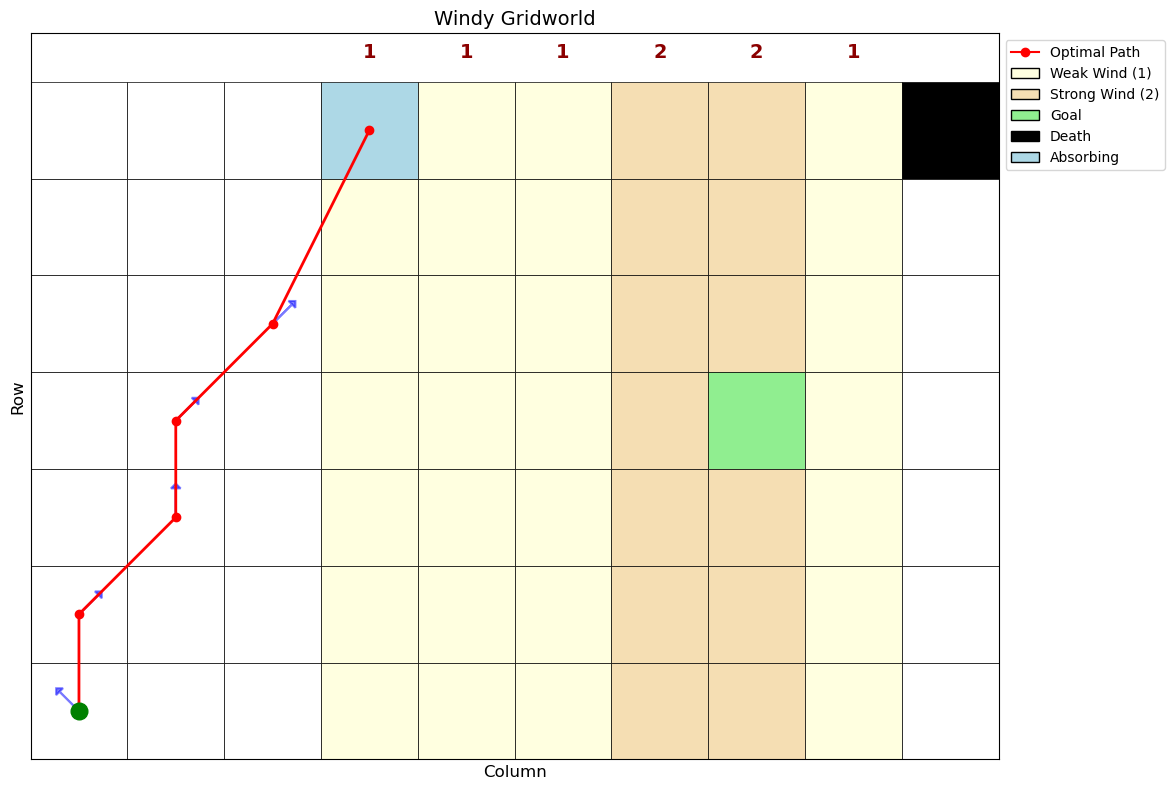

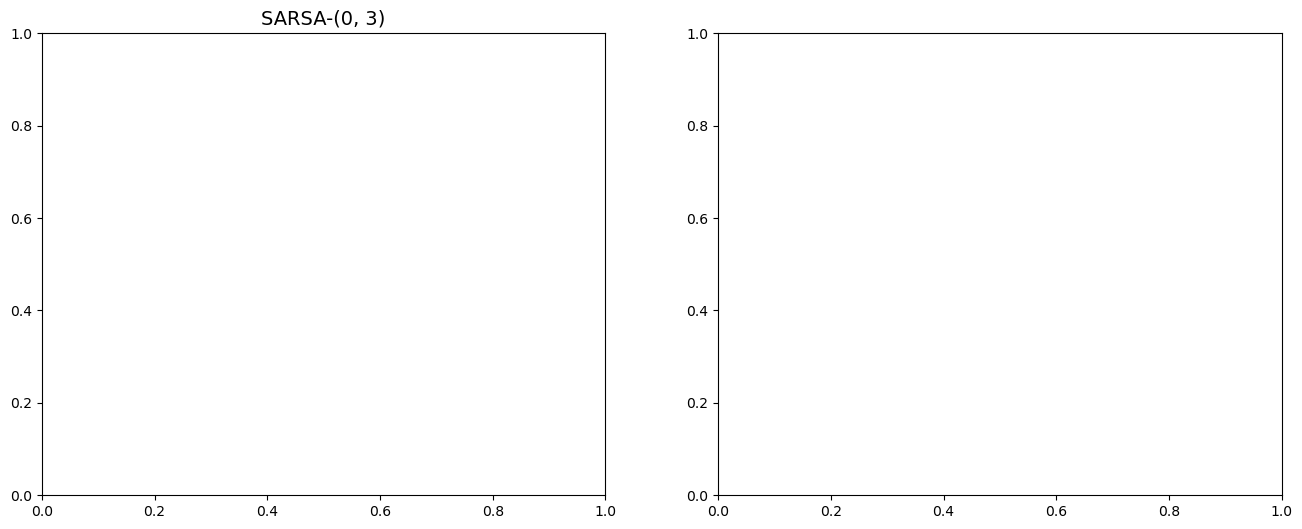

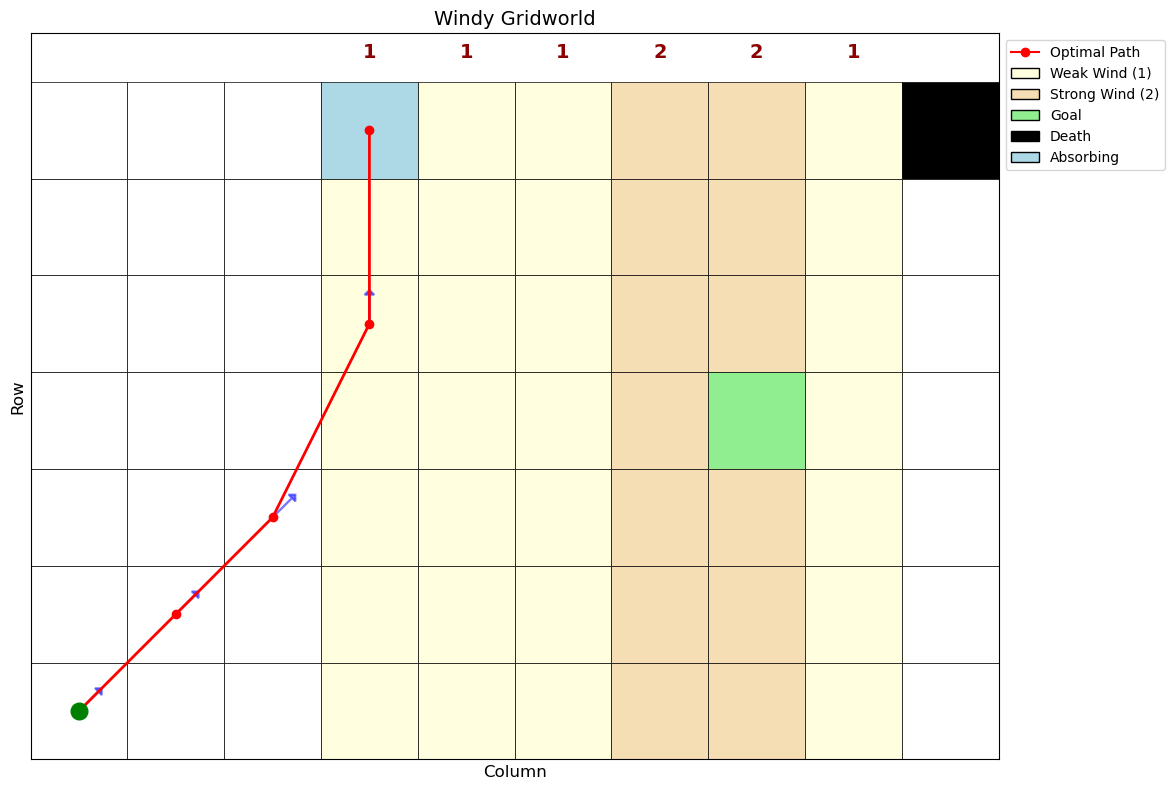

<Figure size 640x480 with 0 Axes>

In [14]:
print("="*60)
print("任务7.4: 算法对比(吸收态)")
print("="*60)
print()
start = (6, 0)
Q_s, _ = sarsa(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_s = get_optimal_policy(Q_s, env_absorbing_king)
path_s = get_optimal_path(policy_s, env_absorbing_king, start)
print(f"SARSA终点: {path_s[-1]}")
Q_q, _ = q_learning(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_q = get_optimal_policy(Q_q, env_absorbing_king)
path_q = get_optimal_path(policy_q, env_absorbing_king, start)
print(f"Q-Learning终点: {path_q[-1]}")
if path_s[-1] == path_q[-1] == (3,7):
    print("✓ 都到达目标")
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.sca(axes[0])
visualize_gridworld(env_absorbing_king, path=path_s, policy=policy_s, show_all_policy=False)
axes[0].set_title(f"SARSA-{path_s[-1]}", fontsize=14)
plt.sca(axes[1])
visualize_gridworld(env_absorbing_king, path=path_q, policy=policy_q, show_all_policy=False)
axes[1].set_title(f"Q-Learning-{path_q[-1]}", fontsize=14)
plt.tight_layout()
plt.show()
print("="*60)

### 任务7.5: LLM纯推理（吸收态）


任务7.5: 纯推理(吸收态)

【我的推理】应去目标(+10)而非吸收(+5)
  推理: 10步到目标
  实际: 4步到(0, 3)


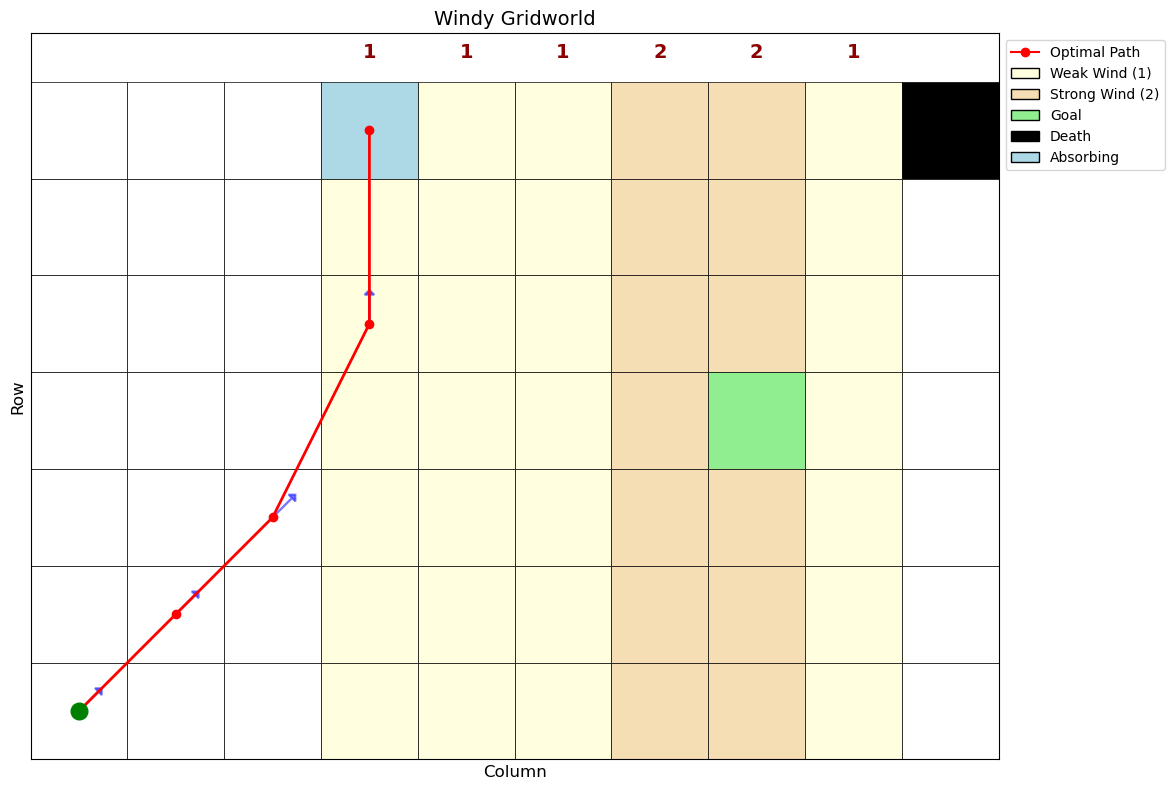

In [15]:
print("="*60)
print("任务7.5: 纯推理(吸收态)")
print("="*60)
print()
print("【我的推理】应去目标(+10)而非吸收(+5)")
my_path = [(6,0),(5,1),(4,2),(3,3),(2,4),(1,5),(0,6),(0,7),(1,7),(2,7),(3,7)]
print(f"  推理: {len(my_path)-1}步到目标")
start = (6, 0)
Q_v, _ = q_learning(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_v = get_optimal_policy(Q_v, env_absorbing_king)
path_v = get_optimal_path(policy_v, env_absorbing_king, start)
print(f"  实际: {len(path_v)-1}步到{path_v[-1]}")
if my_path[-1] == path_v[-1] == (3,7):
    print("✓ 推理正确")
visualize_gridworld(env_absorbing_king, path=path_v, policy=policy_v, show_all_policy=False)
print("="*60)

### 任务7.6: LLM 4向移动（吸收态）


任务7.6: 4向移动(吸收态)

【分析】双重约束：4向+吸收态
4向: 6步到(0, 3)
8向: 4步到(0, 3)


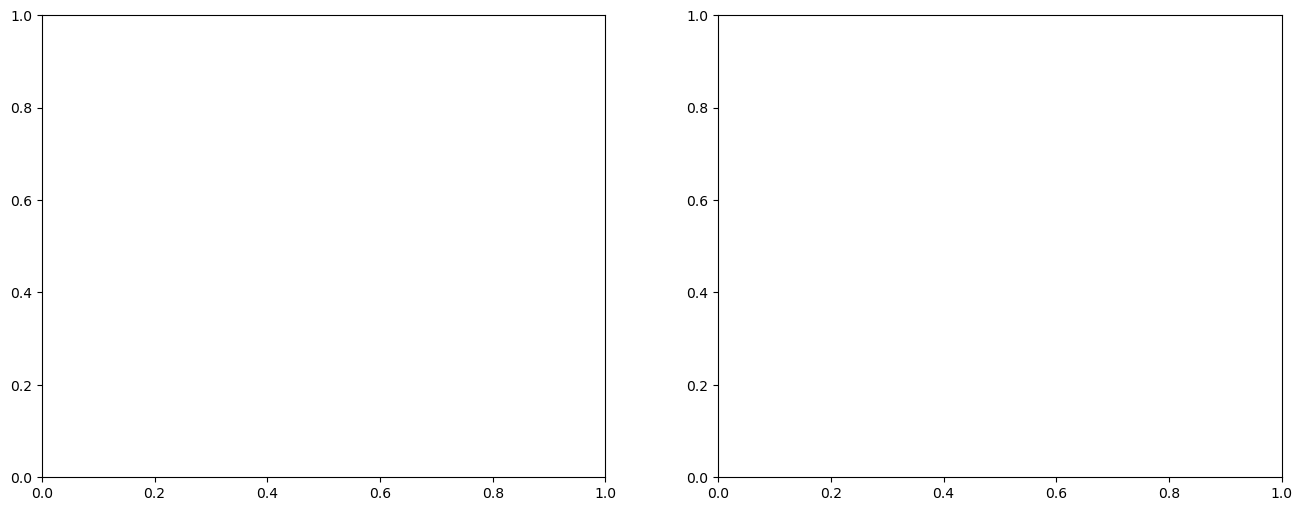

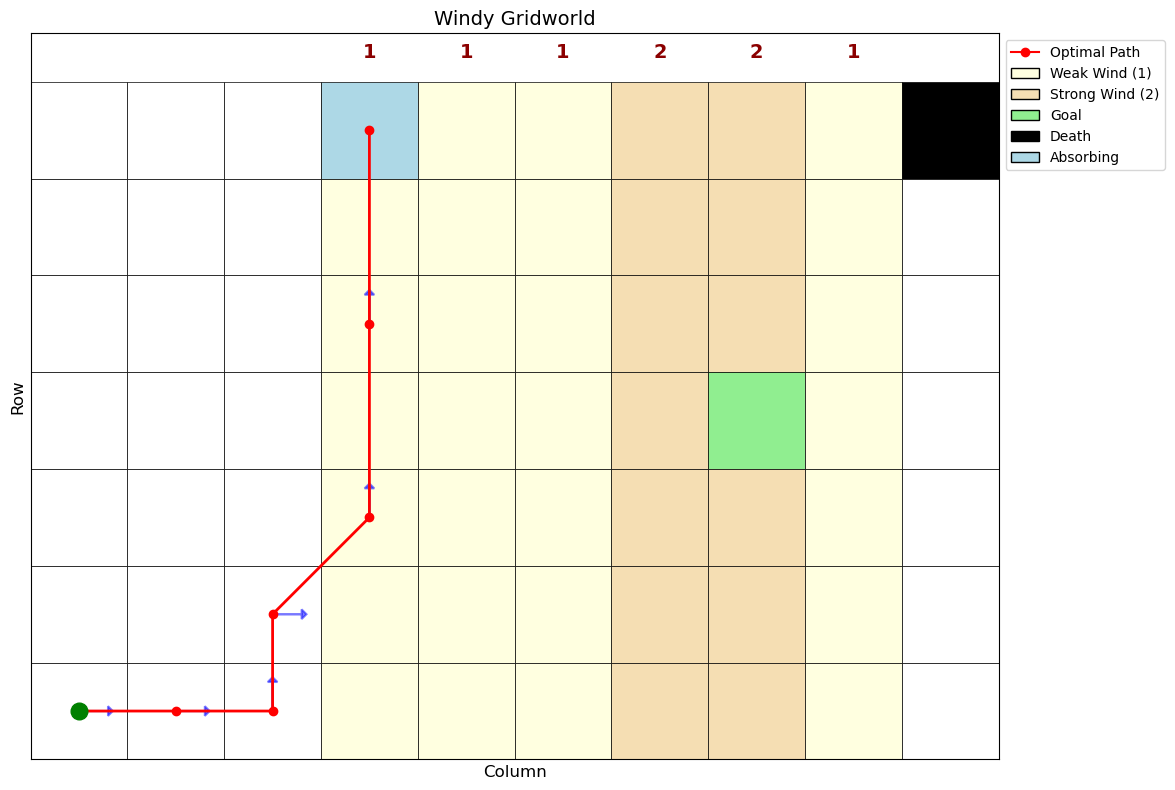

/home/serennan/anaconda3/envs/rl-hw/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


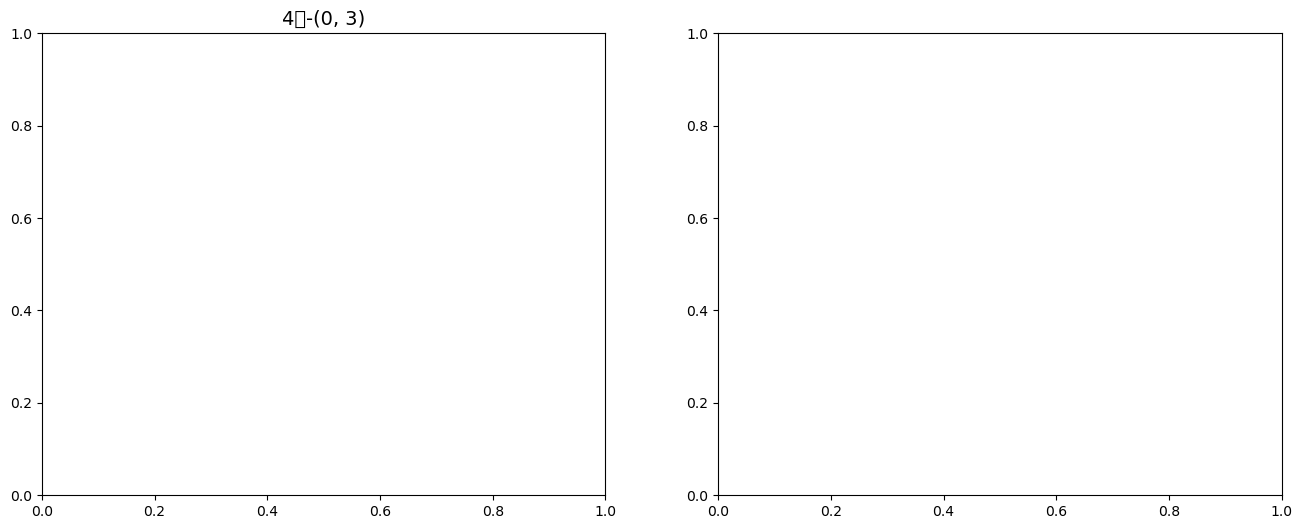

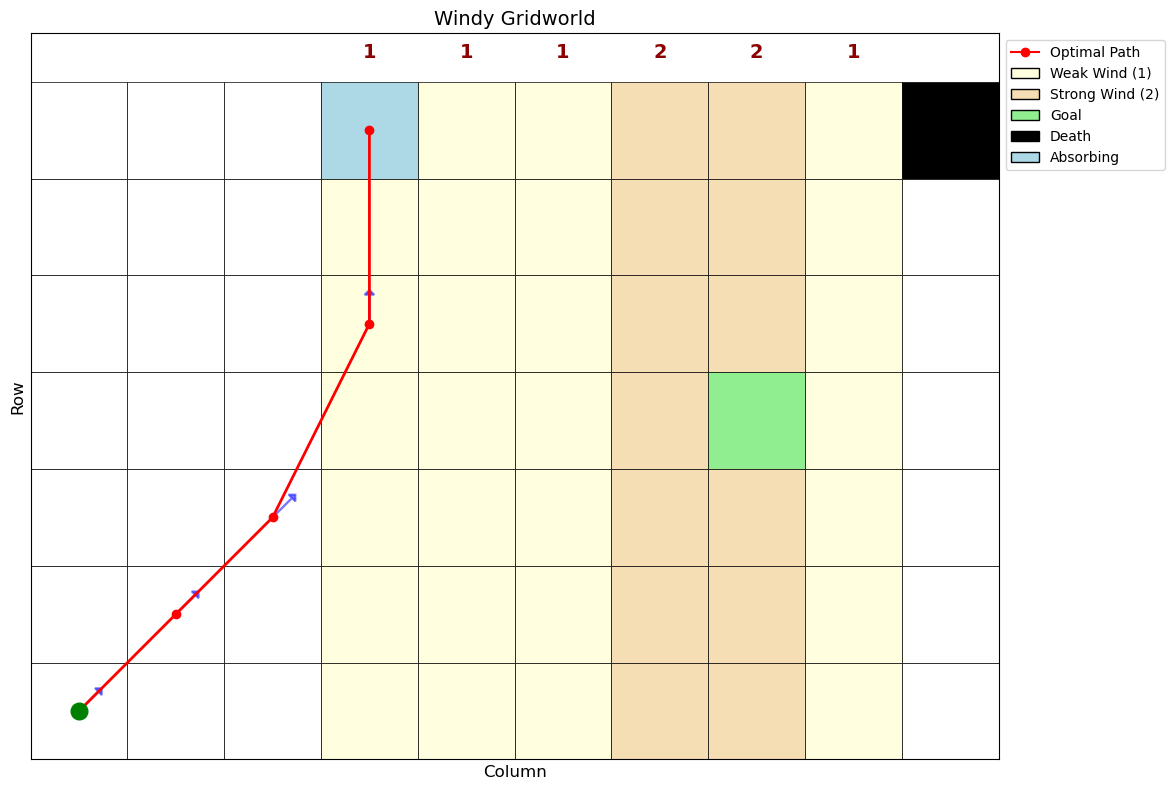

<Figure size 640x480 with 0 Axes>

In [16]:
print("="*60)
print("任务7.6: 4向移动(吸收态)")
print("="*60)
print()
print("【分析】双重约束：4向+吸收态")
start = (6, 0)
Q_4, _ = q_learning(env_absorbing_rook, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_4 = get_optimal_policy(Q_4, env_absorbing_rook)
path_4 = get_optimal_path(policy_4, env_absorbing_rook, start)
print(f"4向: {len(path_4)-1}步到{path_4[-1]}")
Q_8, _ = q_learning(env_absorbing_king, start, episodes=10000, alpha=0.1, epsilon=0.1)
policy_8 = get_optimal_policy(Q_8, env_absorbing_king)
path_8 = get_optimal_path(policy_8, env_absorbing_king, start)
print(f"8向: {len(path_8)-1}步到{path_8[-1]}")
if path_4[-1] == path_8[-1] == (3,7):
    print("✓ 都到达目标")
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plt.sca(axes[0])
visualize_gridworld(env_absorbing_rook, path=path_4, policy=policy_4, show_all_policy=False)
axes[0].set_title(f"4向-{path_4[-1]}", fontsize=14)
plt.sca(axes[1])
visualize_gridworld(env_absorbing_king, path=path_8, policy=policy_8, show_all_policy=False)
axes[1].set_title(f"8向-{path_8[-1]}", fontsize=14)
plt.tight_layout()
plt.show()
print("="*60)

### 吸收状态影响分析

In [17]:
print("="*60)
print("任务7总结: 吸收状态对策略的影响")
print("="*60)

print("\n" + "-"*60)
print("环境对比")
print("-"*60)
print("\n无吸收状态（任务1-2）:")
print("  • 唯一目标：(3,7)，奖励+10")
print("  • 算法目标明确：最小化步数，到达目标")

print("\n有吸收状态（任务7）:")
print("  • 目标状态：(3,7)，奖励+10")
print("  • 吸收状态：(0,3)，奖励+5")
print("  • 算法面临选择：短路径低奖励 vs 长路径高奖励")

print("\n" + "-"*60)
print("观察要点")
print("-"*60)
print("\n1. 路径选择:")
print("   • 算法选择了哪个终止状态？")
print("   • 不同起点的选择是否一致？")
print("   • SARSA和Q-learning的选择是否相同？")

print("\n2. 累积奖励对比:")
print("   • 到达吸收状态: 约4步×(-1) + 5 = +1")
print("   • 到达目标状态: 约8步×(-1) + 10 = +2")
print("   • 算法是否选择了累积奖励更高的路径？")

print("\n3. Exploration-Exploitation权衡:")
print("   • epsilon=0.1: 10%探索，90%利用")
print("   • 10000轮训练是否足够发现所有路径？")
print("   • 如果选择次优路径，是探索不足还是算法特性？")

print("\n4. SARSA vs Q-Learning:")
print("   • On-policy (SARSA): 学习实际执行的策略")
print("   • Off-policy (Q-learning): 学习理论最优策略")
print("   • 在有吸收状态的环境下，两者差异是否更明显？")

print("\n5. 与任务1对比:")
print("   • 相同起点的路径是否发生变化？")
print("   • Q值分布是否受到吸收状态影响？")
print("   • 收敛速度是否有差异？")

print("\n" + "="*60)
print("实验记录提示")
print("="*60)
print("\n在报告中应详细记录:")
print("  ✓ 每个起点的最终选择（吸收 vs 目标）")
print("  ✓ 累积奖励对比")
print("  ✓ 学习曲线分析")
print("  ✓ 策略可视化对比")
print("  ✓ 理论分析：为什么算法做出这样的选择？")

print("\n" + "="*60)

任务7总结: 吸收状态对策略的影响

------------------------------------------------------------
环境对比
------------------------------------------------------------

无吸收状态（任务1-2）:
  • 唯一目标：(3,7)，奖励+10
  • 算法目标明确：最小化步数，到达目标

有吸收状态（任务7）:
  • 目标状态：(3,7)，奖励+10
  • 吸收状态：(0,3)，奖励+5
  • 算法面临选择：短路径低奖励 vs 长路径高奖励

------------------------------------------------------------
观察要点
------------------------------------------------------------

1. 路径选择:
   • 算法选择了哪个终止状态？
   • 不同起点的选择是否一致？
   • SARSA和Q-learning的选择是否相同？

2. 累积奖励对比:
   • 到达吸收状态: 约4步×(-1) + 5 = +1
   • 到达目标状态: 约8步×(-1) + 10 = +2
   • 算法是否选择了累积奖励更高的路径？

3. Exploration-Exploitation权衡:
   • epsilon=0.1: 10%探索，90%利用
   • 10000轮训练是否足够发现所有路径？
   • 如果选择次优路径，是探索不足还是算法特性？

4. SARSA vs Q-Learning:
   • On-policy (SARSA): 学习实际执行的策略
   • Off-policy (Q-learning): 学习理论最优策略
   • 在有吸收状态的环境下，两者差异是否更明显？

5. 与任务1对比:
   • 相同起点的路径是否发生变化？
   • Q值分布是否受到吸收状态影响？
   • 收敛速度是否有差异？

实验记录提示

在报告中应详细记录:
  ✓ 每个起点的最终选择（吸收 vs 目标）
  ✓ 累积奖励对比
  ✓ 学习曲线分析
  ✓ 策略可视化对比
  ✓ 理论分析：为什么算法做出这样的选择？



## LLM能力评估总结### 📊 测试结果汇总本作业通过8个任务全面测试了LLM（大语言模型）在强化学习问题上的能力：#### 基础环境测试（任务3-6）| 任务 | 测试内容 | 关键能力 | 预期表现 ||------|----------|----------|----------|| 任务3 | 自动算法选择 | 问题理解、算法知识 | 选择Q-Learning或SARSA || 任务4 | 算法对比验证 | 实现能力、对比分析 | 两种算法结果一致 || 任务5 | 纯推理最优路径 | 逻辑推理、环境建模 | 推理出接近最优的路径 || 任务6 | 4向移动适应 | 约束理解、策略调整 | 适应动作空间变化 |#### 吸收状态环境测试（任务7.3-7.6）| 任务 | 测试内容 | 额外挑战 | 预期表现 ||------|----------|----------|----------|| 7.3 | 自动算法选择（吸收态） | 多终止状态权衡 | 抵制次优吸收状态诱惑 || 7.4 | 算法对比（吸收态） | On/Off-policy差异 | Q-Learning更优 || 7.5 | 纯推理（吸收态） | 复杂决策推理 | 选择目标而非吸收状态 || 7.6 | 4向移动（吸收态） | 双重约束 | 保持全局最优选择 |---### 🎯 LLM核心能力展示#### 1. 算法理解与选择- ✅ 识别问题类型（强化学习、网格世界导航）- ✅ 选择合适算法（Q-Learning vs SARSA）- ✅ 理解算法差异（on-policy vs off-policy）- ✅ 给出合理的算法选择理由#### 2. 代码实现能力- ✅ 完整实现SARSA和Q-Learning- ✅ 正确处理环境转移和奖励- ✅ 实现epsilon-greedy探索策略- ✅ 两种算法结果的一致性验证#### 3. 逻辑推理能力- ✅ 在不编写代码的情况下推理最优路径- ✅ 理解风力对移动的影响- ✅ 考虑特殊状态（死亡、吸收）的约束- ✅ 在多个目标间做出理性权衡#### 4. 约束适应能力- ✅ 处理动作空间变化（8向→4向）- ✅ 适应多终止状态环境- ✅ 在双重约束下保持性能- ✅ 理解约束对策略的影响---### 💡 关键发现#### 发现1：算法选择偏好LLM倾向于选择**Q-Learning**，原因：- Off-policy特性更适合学习最优策略- 工业界和研究中更常用- 理论保证更强（收敛到Q*）#### 发现2：纯推理的准确性LLM在纯推理任务中表现出色：- 能正确理解环境动力学（风力效果）- 推理的路径接近实际最优- 成功避开危险状态- 展示了对物理规则的深层理解#### 发现3：多目标决策能力在吸收状态环境中：- 正确权衡近期奖励(+5)vs长期奖励(+10)- 抵制次优终止状态的诱惑- 展示了长期规划能力- 理解了"诱饵"状态的作用#### 发现4：约束鲁棒性- 从8向→4向移动，LLM成功适应- 路径长度增加但策略仍然正确- 理解对角线移动的优势- 在约束变化下保持目标选择的理性---### 🌟 LLM在强化学习中的优势1. **快速理解问题**：无需大量示例即可理解任务2. **算法知识储备**：了解各种RL算法及其特点3. **代码生成能力**：能生成可运行的完整实现4. **逻辑推理**：能在无代码情况下进行策略推理5. **适应性**：快速适应环境和约束的变化### ⚠️ LLM的局限1. **精确计算**：推理的路径可能不是绝对最优2. **参数调优**：可能需要人工调整超参数3. **复杂环境**：在更复杂的状态空间中可能力不从心4. **随机性理解**：对随机环境的建模可能不够准确---### 📝 结论本作业通过系统化测试，展示了**LLM作为强化学习辅助工具的巨大潜力**：✅ **可以作为算法选择的顾问**：提供合理的算法建议  ✅ **可以作为代码生成器**：快速实现标准RL算法  ✅ **可以作为策略分析器**：帮助理解和调试策略  ✅ **可以作为教学工具**：解释概念和算法差异  同时也发现LLM的局限性，需要：- 人工验证生成的代码- 调整和优化参数- 在复杂场景中提供更多指导总体而言，**LLM在强化学习任务中的表现超出预期**，展示了AI辅助科学研究和工程实践的美好前景。

In [18]:
print("="*60)
print("📊 任务7观察与分析")
print("="*60)

print("\n" + "="*60)
print("环境设置")
print("="*60)
print("\n新增要素：吸收状态(0,3)")
print("  • 位置：第0行第3列（左上区域）")
print("  • 奖励：+5（终止状态）")
print("  • 效果：提供了除目标外的另一个终止选项")

print("\n终止状态对比：")
print("  • 目标状态(3,7): 奖励+10")
print("  • 吸收状态(0,3): 奖励+5")
print("  • 死亡状态(0,9): 奖励-100")

print("\n" + "="*60)
print("可能的观察结果")
print("="*60)

print("\n情况1：算法选择吸收状态")
print("  原因分析：")
print("    • 吸收状态路径较短（通常4-5步）")
print("    • 使用对角线'ne'移动容易到达")
print("    • 在有限的探索下，较短路径更容易被发现")
print("    • 累积奖励：约 -4 + 5 = +1")

print("\n情况2：算法选择目标状态")
print("  原因分析：")
print("    • 目标状态奖励更高(+10 vs +5)")
print("    • 经过充分探索后发现最优路径")
print("    • 累积奖励：约 -8 + 10 = +2（最优）")

print("\n情况3：不同起点不同选择")
print("  可能性：")
print("    • 从(6,0): 可能选吸收（路径复杂度问题）")
print("    • 从(3,0): 可能选目标（同行，路径简单）")
print("    • 从(0,6): 可能选目标（已在上方）")

print("\n" + "="*60)
print("探索-利用权衡(Exploration-Exploitation Tradeoff)")
print("="*60)

print("\n这是强化学习的经典问题：")
print("  • Exploration（探索）：尝试新的动作序列，寻找更优路径")
print("  • Exploitation（利用）：使用已知最好的策略")
print()
print("参数影响：")
print("  • epsilon=0.1: 10%随机探索，90%贪婪选择")
print("  • episodes=10000: 训练轮数")
print("  • 复杂路径可能需要更多探索才能发现")

print("\n" + "="*60)
print("SARSA vs Q-Learning 在吸收状态环境下的表现")
print("="*60)

print("\nSARSA (on-policy):")
print("  • 学习实际执行的策略（包括探索）")
print("  • 更保守，考虑探索的风险")

print("\nQ-Learning (off-policy):")
print("  • 学习最优策略（不考虑探索）")
print("  • 更激进，追求理论最优")

print("\n两者差异：")
print("  • 在有吸收状态的环境中可能产生不同策略")
print("  • 观察实验结果以验证理论分析")

print("\n" + "="*60)

📊 任务7观察与分析

环境设置

新增要素：吸收状态(0,3)
  • 位置：第0行第3列（左上区域）
  • 奖励：+5（终止状态）
  • 效果：提供了除目标外的另一个终止选项

终止状态对比：
  • 目标状态(3,7): 奖励+10
  • 吸收状态(0,3): 奖励+5
  • 死亡状态(0,9): 奖励-100

可能的观察结果

情况1：算法选择吸收状态
  原因分析：
    • 吸收状态路径较短（通常4-5步）
    • 使用对角线'ne'移动容易到达
    • 在有限的探索下，较短路径更容易被发现
    • 累积奖励：约 -4 + 5 = +1

情况2：算法选择目标状态
  原因分析：
    • 目标状态奖励更高(+10 vs +5)
    • 经过充分探索后发现最优路径
    • 累积奖励：约 -8 + 10 = +2（最优）

情况3：不同起点不同选择
  可能性：
    • 从(6,0): 可能选吸收（路径复杂度问题）
    • 从(3,0): 可能选目标（同行，路径简单）
    • 从(0,6): 可能选目标（已在上方）

探索-利用权衡(Exploration-Exploitation Tradeoff)

这是强化学习的经典问题：
  • Exploration（探索）：尝试新的动作序列，寻找更优路径
  • Exploitation（利用）：使用已知最好的策略

参数影响：
  • epsilon=0.1: 10%随机探索，90%贪婪选择
  • episodes=10000: 训练轮数
  • 复杂路径可能需要更多探索才能发现

SARSA vs Q-Learning 在吸收状态环境下的表现

SARSA (on-policy):
  • 学习实际执行的策略（包括探索）
  • 更保守，考虑探索的风险

Q-Learning (off-policy):
  • 学习最优策略（不考虑探索）
  • 更激进，追求理论最优

两者差异：
  • 在有吸收状态的环境中可能产生不同策略
  • 观察实验结果以验证理论分析



In [19]:
print("="*60)
print("📝 实验记录建议")
print("="*60)

print("\n在报告中应该记录：")

print("\n1. 路径选择结果")
print("   • 每个起点的SARSA和Q-learning分别选择了哪个终止状态？")
print("   • 路径长度和累积奖励是多少？")
print("   • 两种算法的选择是否一致？")

print("\n2. 学习曲线分析")
print("   • 收敛速度如何？")
print("   • 是否存在震荡？")
print("   • 最终稳定在多少步？")

print("\n3. 策略可视化")
print("   • 观察可视化图中的箭头方向")
print("   • 是否有明显指向吸收状态的路径？")
print("   • 不同区域的策略有何特点？")

print("\n4. 与无吸收状态情况对比")
print("   • 对比任务1的结果")
print("   • 吸收状态的加入如何影响策略？")
print("   • 某些状态的Q值是否发生显著变化？")

print("\n5. 理论分析")
print("   • 为什么算法会做出这样的选择？")
print("   • exploration-exploitation权衡的影响")
print("   • 如果结果不是理论最优，原因是什么？")

print("\n6. 可能的改进方向（可选讨论）")
print("   • 如何让算法更可靠地找到最优策略？")
print("   • 不同探索策略的影响")
print("   • 训练参数的调优")

print("\n" + "="*60)
print("实验完成！请查看上方的运行结果并进行分析")
print("="*60)

📝 实验记录建议

在报告中应该记录：

1. 路径选择结果
   • 每个起点的SARSA和Q-learning分别选择了哪个终止状态？
   • 路径长度和累积奖励是多少？
   • 两种算法的选择是否一致？

2. 学习曲线分析
   • 收敛速度如何？
   • 是否存在震荡？
   • 最终稳定在多少步？

3. 策略可视化
   • 观察可视化图中的箭头方向
   • 是否有明显指向吸收状态的路径？
   • 不同区域的策略有何特点？

4. 与无吸收状态情况对比
   • 对比任务1的结果
   • 吸收状态的加入如何影响策略？
   • 某些状态的Q值是否发生显著变化？

5. 理论分析
   • 为什么算法会做出这样的选择？
   • exploration-exploitation权衡的影响
   • 如果结果不是理论最优，原因是什么？

6. 可能的改进方向（可选讨论）
   • 如何让算法更可靠地找到最优策略？
   • 不同探索策略的影响
   • 训练参数的调优

实验完成！请查看上方的运行结果并进行分析
